# coverageAndTails_wAmbiguousReads.ipynb
## Marcus Viscardi,    July 05, 2023

In the past I have been using assignments from FLAIR to determine if a read is from a NMD sensitive isoform or not. While this has worked reasonably well, it was leading to a large number of "ambiguous" assignments, as FLAIR was not confident in complete isoform assignment for a lot of reads.

To alleviate this issue, I wrote the code in `ambiguousReads.py` which utilizes coverage of manually annotated NMD-defining regions of genes. These are the exons or parts of exons that are "define" the difference between the NMD-sensitive isoform(s) and the insensitive.

These manual annotations are just that, ***manual***, so the list is short and suffers from "my best guess" at these things based on my NMD-knockout libs and the literature. I will be adding to this list as I go, but for now it is a good start.

***

Generally, the idea for this file is to rewrite the stuff in `coverageAndTails_wFlairAssignments.ipynb` to use the new read assignment method. I may want to add some more plots to this file, but I will start with the basics!

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sea
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from itertools import product
from pathlib import Path
import pysam
import sys
import warnings
sys.path.insert(0, '/data16/marcus/scripts/nanoporePipelineScripts')
import nanoporePipelineCommon as npC
from nanoporeReadPlotting.finalizingReadAndCoveragePlotting_matplotlib import plot_reads, coverage_plotting_5tera

CONVERSION_DICT = npC.CONVERSION_DICT
REV_CONVERSION_DICT = {val: key for key, val in CONVERSION_DICT.items()}
LIB_NAMES = list(REV_CONVERSION_DICT.keys())
print(f"Finished imports at: {npC.get_dt(for_print=True)}")

Finished imports at: 09/20/23 @ 05:40:16 PM


In [2]:
def bam_tag_to_df(bam, tag, additional_tags=(), chr = None, start=None, stop = None):
    read_names = []
    chrs = []
    chr_starts = []
    tag_vals = []
    if len (additional_tags) >= 1:
        additional_tags_dict = {tag: [] for tag in additional_tags}
        additional_tag_flag = True
    else:
        additional_tags_dict = {}
        additional_tag_flag = False
    for read in bam.fetch(chr, start, stop):
        read_names.append(read.query_name)
        chrs.append(read.reference_name)
        chr_starts.append(read.reference_start)
        tag_vals.append(read.get_tag(tag))
        if additional_tag_flag:
            for add_tag in additional_tags:
                additional_tags_dict[add_tag].append(read.get_tag(add_tag))
    if additional_tag_flag:
        return pd.DataFrame({'read_id': read_names, 'chr_id': chrs, 'chr_pos': chr_starts, tag: tag_vals, **additional_tags_dict})
    else:
        return pd.DataFrame({'read_id': read_names, 'chr_id': chrs, 'chr_pos': chr_starts, tag: tag_vals})


def load_and_merge_w_assignments(lib_nickname, genome_dir="/data16/marcus/genomes/elegansRelease100") -> pd.DataFrame:
    # Load in the reads:
    lib_key = REV_CONVERSION_DICT[lib_nickname]
    read_df_path = npC.pick_lib_return_path(lib_key, file_midfix='_mergedOnReads', file_suffix='.parquet')
    read_df = pd.read_parquet(read_df_path)
    read_df['chr_pos'] -= 1  # I am not sure why this happened between this and the BAM...
    print(f"Loaded {len(read_df)} reads from {lib_nickname}!")
    
    # Load in the assignments:
    assignment_bam_path = npC.pick_lib_return_path(lib_key, output_dir_folder='NMD_targets', file_midfix='.all.merge', file_suffix='.bam')
    assignment_bam = pysam.AlignmentFile(assignment_bam_path, 'rb')
    simple_assignments = bam_tag_to_df(assignment_bam, 'gA', additional_tags=['nC'])
    simple_assignments.rename(columns={'gA': 'gene_id', 'nC': 'nmd_assignment'}, inplace=True)
    print(f"Loaded {len(simple_assignments)} NMD assignments from {lib_nickname}!")
    assignment_bam.close()
    output_df = read_df.merge(simple_assignments,
                              on=['read_id', 'chr_id', 'chr_pos'],
                              how='left',  # "left" keep basically all reads; "inner"/"right" keep only reads with assignments
                              suffixes=["_featCounts", "_myAssignments"],
                              )
    # I want to replace gene_id_myAssignments with "non_nmd_gene" for reads that don't have an assignment:
    output_df.loc[output_df['gene_id_myAssignments'].isna(), 'gene_id_myAssignments'] = 'non_nmd_gene'
    output_df.loc[output_df['nmd_assignment'].isna(), 'nmd_assignment'] = 'non_nmd_target'
    output_df.drop(columns=['gene_id_featCounts', 'gene_name', 'chr'], inplace=True)
    output_df['gene_id'] = output_df['gene_id_myAssignments']
    names_df = npC.gene_names_to_gene_ids(parquet_path=npC.find_newest_matching_file(f"{genome_dir}/*.gtf.parquet"))[['gene_id', 'gene_name']]
    output_df = output_df.merge(names_df, on='gene_id', how='left')
    output_df.gene_name.fillna('non_nmd_gene', inplace=True)
    print(f"Post-merge output_df has {len(output_df)} reads!")
    output_df['lib'] = lib_nickname
    output_df['lib_long'] = lib_key
    return output_df


def load_multiple_libs(nickname_list,
                       regenerate=False,
                       genome_dir="/data16/marcus/genomes/elegansRelease100"):
    try:
        if regenerate:
            raise FileNotFoundError
        temp_save_path = npC.find_newest_matching_file(f"/tmp/*_{'-'.join(nickname_list)}_multi_lib_df.parquet")
        print(f"Loading from {temp_save_path}...", end=" ")
        multi_lib_df = pd.read_parquet(temp_save_path)
        print("Done!")
    except FileNotFoundError:
        print(f"Could not find a matching file in /tmp/*_{'-'.join(nickname_list)}_multi_lib_df.parquet! Generating...")
        multi_lib_df = pd.DataFrame()
        for library_nickname in nickname_list:
            print(f"\n\n{f' Loading {library_nickname}... ':#^50}")
            multi_lib_df = pd.concat([multi_lib_df, load_and_merge_w_assignments(library_nickname, genome_dir=genome_dir)])
        print(f"Loaded {len(multi_lib_df)} reads from {len(nickname_list)} libraries!")
        new_save_path = f"/tmp/{npC.get_dt()}_{'-'.join(nickname_list)}_multi_lib_df.parquet"
        print(f"Saving to {new_save_path}...", end=" ")
        multi_lib_df.to_parquet(new_save_path)
        print("Done!")
    return multi_lib_df

In [4]:
regen = False
lib_nicknames = [
    "oldN2",
    "oldS6",
    "newerN2",
    "newerS5",
    "newerS6",
    "thirdN2",
    "thirdS5",
    "thirdS6",
    ]
output_df = load_multiple_libs(lib_nicknames, regenerate=regen)
output_df

Could not find a matching file in /tmp/*_oldN2-oldS6-newerN2-newerS5-newerS6-thirdN2-thirdS5-thirdS6_multi_lib_df.parquet! Generating...


################ Loading oldN2... ################
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Loaded 701680 reads from oldN2!
Looking for file for xrn-1-5tera, at /data16/marcus/working/211118_nanoporeRun_totalRNA_5108_xrn-1-KD_5TERA/output_dir/NMD_targets/*.all.merge.bam... File Found.
Loaded 17430 NMD assignments from oldN2!
Post-merge output_df has 701680 reads!


################ Loading oldS6... ################
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-KD_5TERA/output_dir/merge_files/*_mergedOnReads.parquet... File Found.
Loaded 236286 reads from oldS6!
Looking for file for xrn-1-5tera-smg-6, at /data16/marcus/working/211210_nanoporeRun_totalRNA_2102_xrn-1-

,read_id,bit_flag,chr_id,chr_pos,mapq,cigar,r_next,p_next,len,sequence,phred_qual,AS,NM,SA,cm,de,ms,nn,rl,s1,s2,t3,t5,tp,ts,zd,strand,qc_tag_featc,qc_pass_featc,leader_start,adapter_start,polya_start,transcript_start,read_rate,polya_length,qc_tag_polya,read_length,gene_id_myAssignments,nmd_assignment,gene_id,gene_name,lib,lib_long
0,da3cb784-8c38-4653-8d8d-2243d229302c,16,I,3745,60,221S25M1I11M1D59M2D14M1D39M,*,0,0,GTTTGAGGATGGTAGGGGTTAGGATGATGATGAGGCATATGTTGGG...,"$$%+%$&')('/+*)'('""$$%&$%%($""%$'$%$#'('#%%%))%...",135,5,"IV,8188737,+,150S141M4I75S,60,14;",30,0.0263,135,0,0,129,0,-,-,P,+,NaN,-,Assigned,1.0,2.0,3.0,4850.0,8770.0,107.57,134.96,PASS,370,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,oldN2,xrn-1-5tera
1,fbb406be-4daf-4632-b619-308dc18ebbe7,16,I,3745,60,41S5M1I25M2I4M1I31M2D49M1I5M1I10M1I17M,*,0,0,GCTTTTTTACGCAAATTGGCTTCATTTTGGGGGGGTTTTTAAGAGG...,"$$#%*/112-/8:02;=9143.3&&((0)00.,*))+4<679)$0....",111,13,None,23,0.0719,111,0,0,104,0,-,-,P,+,NaN,-,Assigned,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,194,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,oldN2,xrn-1-5tera
2,9eec2396-846e-4b38-8c2c-111d2823a50e,16,I,3746,60,120S33M2I65M1I40M1D12M,*,0,0,ATTTTTTTTACGCTGAAAGCCCGATGAGGAGGCATATTTATAGATA...,"#%'.//35333/<)58&78;;//455/10425:>,5(<7658158=...",137,5,"I,379069,-,7S113M6D153S,48,12;",31,0.0261,137,0,0,128,0,-,-,P,+,NaN,-,Assigned,1.0,2.0,3.0,5836.0,7596.0,115.85,62.65,PASS,273,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,oldN2,xrn-1-5tera
3,6cc186eb-2f9c-4056-965f-ac214a40c7c4,16,I,3747,60,133S27M1D13M3D6M3D7M3D65M1D24M,*,0,0,ATTTTGGATGATCAATACTTTATTATGTATATTTTGCTGTTCAAGA...,"+-./.)$'87922B:4573,,,$.*.0/,&-64751464'+3,-%'...",121,11,"I,6849785,+,144S125M12D6S,45,14;",29,0.0340,121,0,0,111,0,-,-,P,+,NaN,-,Assigned,1.0,2.0,3.0,5171.0,5910.0,130.96,27.09,PASS,275,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,oldN2,xrn-1-5tera
4,37a56425-45ea-4499-9604-d255d54dad68,16,I,3755,60,169S42M3D28M1D43M2D10M2D8M,*,0,0,AGTTAATAAGAAGGGATGATGTAGGATAGGGGATAGGATGTAGATG...,"&$$%(*$&$%&+)5&-&(##&#$*&$$#$*(%$#$&%$)$#$#',)...",103,12,None,21,0.0593,103,0,15,101,0,-,-,P,+,NaN,-,Assigned,1.0,2.0,3.0,5860.0,6825.0,130.96,36.91,PASS,300,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,oldN2,xrn-1-5tera
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560894,c10c56c0-4160-4a4b-871e-10a13d24350d,0,cerENO2,528,30,29M1D6M1D97M10S,*,0,0,GCTCCAAACTTACAAACTGCTGAAGAAGCTTGGACTGATTGTTGAC...,).;<<@20))($.><;.2.&:88EA;<=)=3*(8089::A?DEG<;...,83,22,None,12,0.0427,83,17,0,58,0,-,-,P,+,NaN,+,Assigned,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,142,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,thirdS6,5tera_xrn-1-KD_smg-6_third
560895,c9551275-a61e-44f8-afad-909f451e48b5,0,cerENO2,535,54,29M1D50M1D46M4S,*,0,0,ACATTCAAACTGCTGAAGAAGCTTTGGACTGATTGTTGACGCCATC...,"))&(49;4'364(01*),+B?5(.-632(4744=@CG8@>8BC957...",81,20,None,13,0.0273,81,17,0,72,0,-,-,P,+,NaN,+,Assigned,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,129,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,thirdS6,5tera_xrn-1-KD_smg-6_third
560896,f0714af6-e2e2-441d-94f3-41c4c812899e,0,cerENO2,540,60,75M1D27M1I19M7S,*,0,0,CAAACCGCTGAAGAAGCTTTGGACTTGATTGTTGACGCCATCGTCG...,"$0*)(+(%--2?<=>A1*1;-*8*%7:=95(,F<A>9=D=688=><...",83,18,None,20,0.0094,83,17,0,79,0,-,-,P,+,NaN,+,Assigned,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,129,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,thirdS6,5tera_xrn-1-KD_smg-6_third
560897,38ab2f8e-301f-4c8c-93a6-9f1e05a9b93f,0,cerENO2,541,60,21M1I52M2D46M5S,*,0,0,AAACCGCTGAAGAAGCTTTGGAACTTGATTGTTGACGCCATCGTCG...,"38:763'1.,><CNC4//<86+',(0/209/18;9,85<44+*+11...",80,19,None,16,0.0096,80,17,0,77,0,-,+,P,+,NaN,+,Assigned,1.0,NaN,NaN,NaN,NaN,NaN,NaN,None,125,non_nmd_gene,non_nmd_target,non_nmd_gene,non_nmd_gene,thirdS6,5tera_xrn-1-KD_smg-6_third


### Coverage plots

In [5]:
import itertools
from scipy import stats
TARG_ADAPT_CONVERTER_DICT = {"NMD'ed: +  t5: +": "Cleaved NMD Targets (Red Dashed)",
                             "NMD'ed: +  t5: -": "Full-Length NMD Targets (Red Solid)",
                             "NMD'ed: -  t5: +": "Cleaved Non-Targets (Blue Dashed)",
                             "NMD'ed: -  t5: -": "Full-Length Non-Targets (Blue Solid)",
                             "NMD'ed: ~  t5: +": "Cleaved Ambiguous (Gray Dashed)",
                             "NMD'ed: ~  t5: -": "Full-Length Ambiguous (Gray Solid)",
                             }
TARG_ADAPT_EXPAND_DICT = {"NMD'ed: +  t5: +": "/+,/+",
                          "NMD'ed: +  t5: -": "/+,-",
                          "NMD'ed: -  t5: +": "-,/+",
                          "NMD'ed: -  t5: -": "-,-",
                          "NMD'ed: ~  t5: +": "~,/+",
                          "NMD'ed: ~  t5: -": "~,-",
                          }

def plots_tails_ecdf(library_df, targeted_gene,
                     lib_target,
                     save_dir=f"./output_files/isoform_plots/NMD_and_Adapted_tailPlots",
                     given_ax=None,
                     log_xaxis=True,
                     do_not_plot_less_than=0,
                     perform_kstest=True,
                     perform_mannwhitney=True,
                     pallete_overwrite=None,
                     quiet=False,
                     ):
    if isinstance(pallete_overwrite, dict):
        palette = pallete_overwrite
    else:
        # palette = {"NMD'ed: +  t5: -": "darkred",
        #            "NMD'ed: +  t5: +": "red", 
        #            "NMD'ed: -  t5: -": "darkblue",
        #            "NMD'ed: -  t5: +": "blue",
        #            "NMD'ed: ~  t5: -": "darkgray",
        #            "NMD'ed: ~  t5: +": "gray"}
        palette = {"NMD'ed: +  t5: -": '#16502dff',
                   "NMD'ed: +  t5: +": '#37c871ff', 
                   "NMD'ed: -  t5: -": '#00008bff',
                   "NMD'ed: -  t5: +": '#64a7ffff',
                   "NMD'ed: ~  t5: -": '#414141ff',
                   "NMD'ed: ~  t5: +": '#676767ff'}
    library_df = library_df[library_df.NMD_and_t5.isin(palette.keys())]
    
    if given_ax:
        ax = given_ax
    else:
        _, ax = plt.subplots(figsize=(8, 6))
    # Drop lines with less than do_not_plot_less_than reads:
    kept_keys = []
    for key in palette.keys():
        # Check how many entries match each key in NMD_and_t5:
        num_entries = len(library_df[(library_df['NMD_and_t5'] == key) & ~library_df['polya_length'].isna()])
        if num_entries < do_not_plot_less_than:
            library_df = library_df[library_df['NMD_and_t5'] != key]
        else:
            kept_keys.append(key)
    
    # Before plotting lets do some stats:
    do_stats = perform_kstest or perform_mannwhitney
    if do_stats:
        combinations_to_compare = list(itertools.combinations(kept_keys, 2))
        tails_dict = {key: library_df[(library_df['NMD_and_t5'] == key) & ~library_df['polya_length'].isna()]['polya_length'].to_list() for key in kept_keys}
        for set_1, set_2 in combinations_to_compare:
            # print(f"\n{TARG_ADAPT_CONVERTER_DICT[set_1]} vs {TARG_ADAPT_CONVERTER_DICT[set_2]} [{targeted_gene} in {lib_target}]:")
            if not quiet:
                print(f"{TARG_ADAPT_EXPAND_DICT[set_1]},{TARG_ADAPT_EXPAND_DICT[set_2]},{targeted_gene},{lib_target}", end=",")
            if perform_kstest:
                ks_res = stats.ks_2samp(tails_dict[set_1], tails_dict[set_2])
                if not quiet:
                    print(f"{ks_res.statistic},{ks_res.pvalue}", end=",")
                # print(f"\tKolmogorov-Smirnov test: {ks_res}")
            if perform_mannwhitney:
                mwu_res = stats.mannwhitneyu(tails_dict[set_1], tails_dict[set_2])
                if not quiet:
                    print(f"{mwu_res.statistic},{mwu_res.pvalue}", end=",")
                # print(f"\tMann-Whitney test: {mwu_res}")
            print()
    
    
    g = sea.ecdfplot(library_df.sort_values('NMD_and_t5'),
                     ax=ax,
                     x='polya_length',
                     hue='NMD_and_t5',
                     palette=palette,
                     log_scale=log_xaxis,
                     )
    
    dashed_line_colors = [palette[key] for key in palette.keys() if "t5: +" in key]
    # Change the line styles:
    for i, line in enumerate(g.lines):
        # if line.get_color().startswith("dark"):
        #     line.set_linestyle("-")
        # else:
        #     line.set_linestyle("--")
        if line.get_color() in dashed_line_colors:
            line.set_linestyle("--")
        else:
            line.set_linestyle("-")
    if not given_ax:
        plt.title(f"Tail lengths from {lib_target} for {targeted_gene}")
    if log_xaxis:
        ax.set_xbound(10, 200)
        ax.set_xticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
        ax.set_xticklabels([10, 20, 30, 40, 50, None, 70, None, None, 100, 200])
    else:
        ax.set_xbound(-1, 200)
    # sea.move_legend(g, "lower right")
    ax.get_legend().remove()
    if not given_ax:
        plt.tight_layout()
    if isinstance(save_dir, str) and not given_ax:
        save_dir = Path(save_dir)
        if not save_dir.exists():
            print(f"Making new directory at: {save_dir}")
            save_dir.mkdir()
        
        save_path = str(save_dir) + f"/{npC.get_dt()}_{targeted_gene}_{lib_target}_NMD-and-t5_tailLength.ecdf"
        if log_xaxis:
            save_path += ".logAxis"
        for file_type in ['.svg', '.png']:
            plt.savefig(save_path + file_type, dpi=300)
        plt.show()
    elif not given_ax:
        plt.show()


def plots_tails_violin(library_df, targeted_gene,
                     lib_target,
                     save_dir=f"./output_files/isoform_plots/NMD_and_Adapted_tailPlots",
                     given_ax=None,
                     log_yaxis=True,
                     ):
    palette = {"NMD'ed: +  t5: -":"darkred",
               "NMD'ed: +  t5: +":"red", 
               "NMD'ed: -  t5: -":"darkblue",
               "NMD'ed: -  t5: +":"blue",
               "NMD'ed: ~  t5: -":"darkgray",
               "NMD'ed: ~  t5: +":"gray"}
    
    if given_ax:
        ax = given_ax
    else:
        _, ax = plt.subplots(figsize=(8, 6))
    g = sea.violinplot(library_df.sort_values('NMD_and_t5'),
                       ax=ax,
                       y='polya_length',
                       x='NMD_Sensitive_Isoform',
                       hue='t5',
                       # palette=palette,
                       cut=0,
                       split=True,
                       inner='stick',
                       )
    if not given_ax:
        plt.title(f"Tail lengths from {lib_target} for {targeted_gene}")
    if log_yaxis:
        ax.set_ybound(10, 200)
        ax.set_yticks([10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
        ax.set_yticklabels([10, 20, 30, 40, 50, None, 70, None, None, 100, 200])
    else:
        ax.set_ybound(-1, 200)
    # sea.move_legend(g, "lower right")
    # ax.get_legend().remove()
    if not given_ax:
        plt.tight_layout()
    if isinstance(save_dir, str):
        save_dir = Path(save_dir)
        if not save_dir.exists():
            print(f"Making new directory at: {save_dir}")
            save_dir.mkdir()
        
        save_path = str(save_dir) + f"/{npC.get_dt()}_{targeted_gene}_{lib_target}_NMD-and-t5_tailLength.violin"
        if log_yaxis:
            save_path += ".logAxis"
        for file_type in ['.svg', '.png']:
            plt.savefig(save_path + file_type, dpi=300)
        plt.show()


def plot_tails_and_coverage(df, target_gene, lib,
                            quiet=False, save_dir=None,
                            seaborn_context='talk',
                            log_tails=True,
                            ecdf_tails=True,
                            do_not_plot_less_than=0,
                            tails_kstest=True,
                            tails_mannwhitney=True,
                            skip_coverage=False,
                            pallete_overwrite=None,
                            ):
    sea.set_style("whitegrid")
    sea.set_context(seaborn_context)
    if isinstance(pallete_overwrite, dict):
        palette = pallete_overwrite
    else:
        palette = {"NMD'ed: +  t5: -": '#16502dff',
                   "NMD'ed: +  t5: +": '#37c871ff', 
                   "NMD'ed: -  t5: -": '#00008bff',
                   "NMD'ed: -  t5: +": '#64a7ffff',
                   "NMD'ed: ~  t5: -": '#414141ff',
                   "NMD'ed: ~  t5: +": '#676767ff'}
    
    ### Process dataframe >>>
    ### 7/11/2023: This is the only place where I really made any changes! Everything else from the old scripts should "just work"!
    df = df.query(f"lib == @lib").copy()
    df.loc[:, 'NMD_Sensitive_Read'] = df['nmd_assignment'].replace({'nmd_target': '+',
                                                             'non_nmd_target': '-',
                                                             'ambiguous': '~'})
    df['NMD_and_t5'] = df.apply(lambda row: f"NMD'ed: {str(row['NMD_Sensitive_Read'])}  t5: {row['t5']}", axis=1)
    if not quiet:
        print(df['NMD_Sensitive_Read'].value_counts())
        print(df['NMD_and_t5'].value_counts())
    ### <<< Process dataframe
    
    
    ### Build plot >>>
    single_nest = [
        ['target_adapted', 'tails'],
        ['target_unadapted', 'tails'],
        ['non_target_adapted', 'tails'],
        ['non_target_unadapted', 'tails'],
        ['ambiguous_adapted', 'tails'],
        ['ambiguous_unadapted', 'tails'],
        ['space_for_annotations', 'tails']
    ]
    fig, axd = plt.subplot_mosaic(single_nest,
                                  # layout="constrained",
                                  figsize=(15,7),
                                  height_ratios=(1,2,1,2,1,2,1), 
                                  width_ratios=(2,4))
    
    adapted_axes = [ax for name, ax in axd.items() if name.endswith('_adapted')]
    unadapted_axes = [ax for name, ax in axd.items() if name.endswith('_unadapted')]
    ### <<< Build plot
    
    
    ### Plot coverage >>>
    if not skip_coverage:
        assignment_types_axes = []
        for assignment_type in ['target', 'non_target', 'ambiguous']:
            assignment_types_axes.append([ax for name, ax in axd.items() if name.startswith(assignment_type)])
        
        plot_colors = ('red', 'blue', 'gray')
        
        axes_iterator = zip(['+', '-', '~'], assignment_types_axes, plot_colors)
        for assignment, assignment_axes, plot_color in axes_iterator:  # Either two steps here or three (if ambiguous reads getting plotted!)
            if not quiet:
                print(f"Calculating coverage for NMD-({assignment}) isoform in {lib} library:")
                # print(lib_df.query(f"NMD_Sensitive_Isoform == '{target}'"))
                print(assignment, assignment_axes)
            adapted_color = palette[f"NMD'ed: {assignment}  t5: +"]
            unadapted_color = palette[f"NMD'ed: {assignment}  t5: -"]
            coverage_plotting_5tera(df,
                                    gene_name=target_gene,
                                    provide_axes=assignment_axes,
                                    rpm_normalize=True,
                                    additional_plot_df_query=f"NMD_Sensitive_Read == '{assignment}'",
                                    quiet=quiet,
                                    adapted_color=adapted_color,
                                    unadapted_color=unadapted_color,
                                    )
        
        adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
        unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)
        
        for ax in adapted_axes + unadapted_axes:
            ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
    ### <<< Plot coverage
    
    ### Plot tails >>>
    gene_df = df.query(f"gene_name == '{target_gene}'")
    if ecdf_tails:
        plots_tails_ecdf(gene_df, target_gene, lib,
                         given_ax=axd['tails'],
                         save_dir=None,
                         log_xaxis=log_tails,
                         do_not_plot_less_than=do_not_plot_less_than,
                         perform_kstest=tails_kstest,
                         perform_mannwhitney=tails_mannwhitney,
                         pallete_overwrite=palette,
                         quiet=quiet,
                         )
    else:
        plots_tails_violin(gene_df, target_gene, lib,
                           given_ax=axd['tails'],
                           save_dir=None,
                           log_yaxis=log_tails)
    ### <<< Plot tails
    
    ### Final cleanup >>>
    annotation_ax = axd['space_for_annotations']
    annotation_ax.grid(False)
    annotation_ax.axis('off')
    annotation_ax.set_xticklabels([])
    annotation_ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0.25, hspace=0.30)
    plt.suptitle(f'{target_gene} in {lib}')
    ### <<< Final cleanup
    
    ### Save plot >>>
    if isinstance(save_dir, str):
        save_dir = Path(save_dir)
        if not save_dir.exists():
            save_dir.mkdir()
        plot_file_name = f"{npC.get_dt()}_{target_gene}_{lib}_coverageAndTailsPlots"
        for file_type in ('.svg', '.png'):
            save_path = str(save_dir) + '/' + plot_file_name + file_type
            plt.savefig(save_path)
    else:
        plt.show()
    ### <<< Save plot
    return fig, axd


def plot_coverage_multilib(input_df, target_gene, libs,
                           quiet=False, save_dir=None,
                           seaborn_context='talk',
                           font_size=25,
                           additional_width_factor=1,
                           ):
    sea.set_style("whitegrid")
    sea.set_context(seaborn_context)
    # Process dataframe and restrict to only the libraries we want >>>
    df = input_df.copy()
    df = df[df.lib.isin(libs)]
    df['NMD_Sensitive_Read'] = df['nmd_assignment'].replace({'nmd_target': '+',
                                                             'non_nmd_target': '-',
                                                             'ambiguous': '~'})
    df['NMD_and_t5'] = df.apply(lambda row: f"NMD'ed: {str(row['NMD_Sensitive_Read'])}  t5: {row['t5']}", axis=1)
    # if not quiet:
    #     print(df[['lib', 'NMD_Sensitive_Read']].value_counts())
    #     print(df[['lib', 'NMD_and_t5']].value_counts())
    # <<<
    
    # Build Plot >>>
    # This is to prempt any issues with not having all the libs
    actual_libs = list(df.lib.unique())
    actual_libs = [lib for lib in libs if lib in actual_libs]
    adaptable_nest = [
        [f'target_adapted_{library}' for library in actual_libs],
        [f'target_unadapted_{library}' for library in actual_libs],
        [f'non_target_adapted_{library}' for library in actual_libs],
        [f'non_target_unadapted_{library}' for library in actual_libs],
        [f'ambiguous_adapted_{library}' for library in actual_libs],
        [f'ambiguous_unadapted_{library}' for library in actual_libs],
        ['space_for_annotations' for _ in actual_libs],
    ]
    
    fig, axd = plt.subplot_mosaic(adaptable_nest,
                                  # layout="constrained",
                                  figsize=(
                                      5 * len(actual_libs) * additional_width_factor,  # Width
                                      7,                                               # Height
                                  ),
                                  height_ratios=(1,2,1,2,1,2,1), 
                                  width_ratios=list(1 for _ in actual_libs))
    adapted_axes = [ax for name, ax in axd.items() if '_adapted_' in name]
    unadapted_axes = [ax for name, ax in axd.items() if '_unadapted_' in name]
    ### <<< Build plot
    
    
    ### Plot coverage >>>
    for library in actual_libs:
        lib_df = df.query(f"lib == @library")
        assignment_types_axes = []
        for assignment_type in ['target', 'non_target', 'ambiguous']:
            assignment_types_axes.append([ax for name, ax in axd.items() if name.startswith(assignment_type) and name.endswith(library)])
        
        # These colors are updated from the final plots!
        plot_colors = (('#37c871ff', '#16502dff'),  # NMD greens
                       ('#64a7ffff', '#00008bff'),  # Non NMD blues
                       ('#676767ff', '#414141ff'),  # ambiguous greys
                       )
        
        axes_iterator = zip(['+', '-', '~'], assignment_types_axes, plot_colors)
        for assignment, assignment_axes, (adapted_color, unadapted_color) in axes_iterator:  # Either two steps here or three (if ambiguous reads getting plotted!)
            if not quiet:
                print(f"Calculating coverage for NMD-({assignment}) isoform in {library} library:")
                # print(lib_df.query(f"NMD_Sensitive_Isoform == '{target}'"))
                # print(assignment, assignment_axes)
            coverage_plotting_5tera(lib_df,
                                    gene_name=target_gene,
                                    provide_axes=assignment_axes,
                                    rpm_normalize=True,
                                    additional_plot_df_query=f"NMD_Sensitive_Read == '{assignment}'",
                                    quiet=True,
                                    adapted_color=adapted_color,
                                    unadapted_color=unadapted_color,
                                    )
            if assignment == '+':
                assignment_axes[0].title.set_text(library)
    ### <<< Plot coverage
    
    ### Join for shared y axes >>>
    # The join functionality is going to be deprecated in the future, but I don't know how to do this without it!
    # The bit of code below silences the warning about this deprecation IFF the matplotlib version is less than 3.8.
    matplotlib_version = mpl.__version__
    maximum_version = '3.8'
    if matplotlib_version > maximum_version:
        raise ValueError(f"Matplotlib version {matplotlib_version} is greater than {maximum_version}. "
                         f"Please use a version <= {maximum_version} in order to leverage the axes.join() functionality.")
    else:
        warnings.filterwarnings("ignore", category=mpl.MatplotlibDeprecationWarning)
    adapted_axes[0].get_shared_y_axes().join(*adapted_axes)
    unadapted_axes[0].get_shared_y_axes().join(*unadapted_axes)
    for ax in adapted_axes + unadapted_axes:
        ax.yaxis.get_major_ticks()[1].label1.set_visible(False)
    ### <<< Join for shared y axes
    
    ### Make coverage plots prettier >>>
    # The main thing we want to do here is make all the outline lines black:
    for ax in adapted_axes + unadapted_axes:
        ax.spines['top'].set_color('black')
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.spines['right'].set_color('black')
        ax.tick_params(axis='y', colors='black', labelsize=font_size)
    
    
    ### Final cleanup >>>
    annotation_ax = axd['space_for_annotations']
    annotation_ax.grid(False)
    annotation_ax.axis('off')
    annotation_ax.set_xticklabels([])
    annotation_ax.set_yticklabels([])
    plt.subplots_adjust(wspace=0.25, hspace=0.30)
    plt.suptitle(f"{target_gene} in {', '.join(actual_libs)}")
    for text in fig.findobj(plt.Text):
        if text.get_text() != '':
            text.set_fontsize(font_size)
    ### <<< Final cleanup
    
    ### Save plot >>>
    if isinstance(save_dir, str):
        save_dir = Path(save_dir)
        if not save_dir.exists():
            save_dir.mkdir(parents=True, exist_ok=True)
        plot_file_name = f"{npC.get_dt()}_{target_gene}_{'-'.join(actual_libs)}_coverageAndTailsPlots"
        for file_type in ('svg', 'png'):
            (save_dir / f'{file_type}s').mkdir(parents=True, exist_ok=True)
            save_path = str(save_dir) + f'/{file_type}s/' + plot_file_name + '.' + file_type
            plt.savefig(save_path)
    else:
        plt.show()
    ### <<< Save plot
    return fig, axd

Working on C53H9.2...
Calculating coverage for NMD-(+) isoform in oldN2 library:
Calculating coverage for NMD-(-) isoform in oldN2 library:
Calculating coverage for NMD-(~) isoform in oldN2 library:
Calculating coverage for NMD-(+) isoform in newerN2 library:
Calculating coverage for NMD-(-) isoform in newerN2 library:
Calculating coverage for NMD-(~) isoform in newerN2 library:
Calculating coverage for NMD-(+) isoform in newerS5 library:
Calculating coverage for NMD-(-) isoform in newerS5 library:
Calculating coverage for NMD-(~) isoform in newerS5 library:
Calculating coverage for NMD-(+) isoform in newerS6 library:
Calculating coverage for NMD-(-) isoform in newerS6 library:
Calculating coverage for NMD-(~) isoform in newerS6 library:
Calculating coverage for NMD-(+) isoform in thirdN2 library:
Calculating coverage for NMD-(-) isoform in thirdN2 library:
Calculating coverage for NMD-(~) isoform in thirdN2 library:
Calculating coverage for NMD-(+) isoform in thirdS5 library:
Calculat

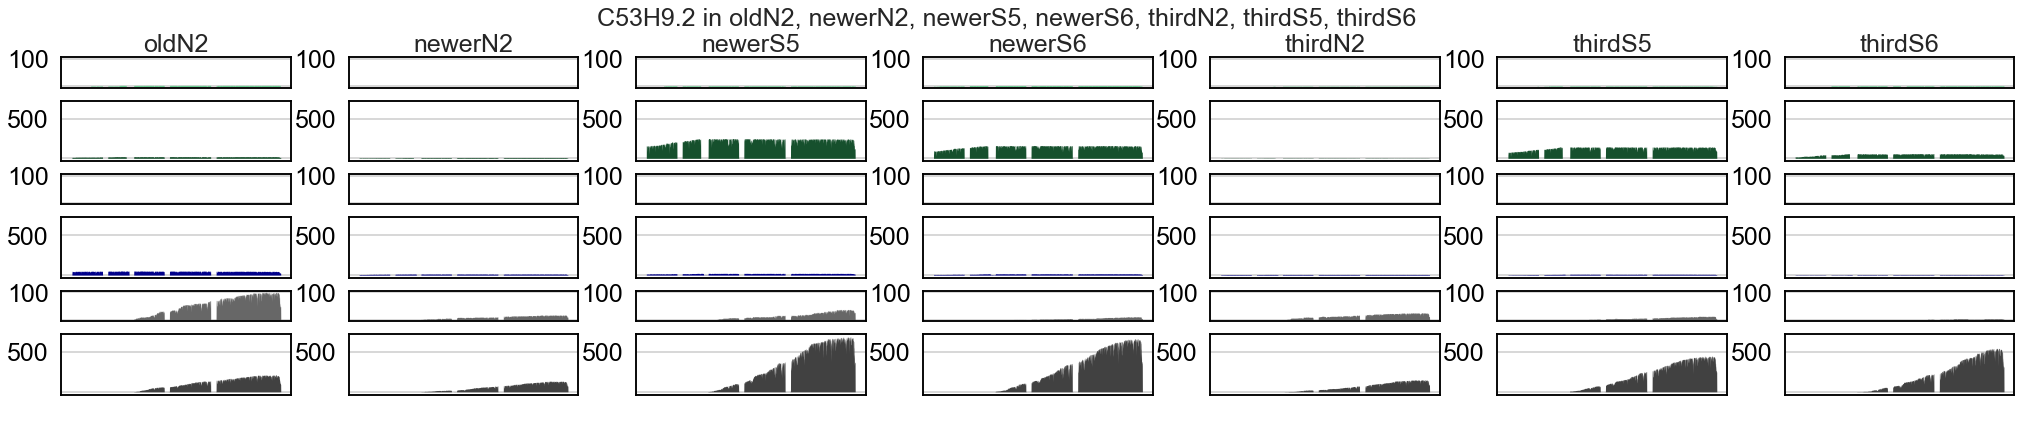

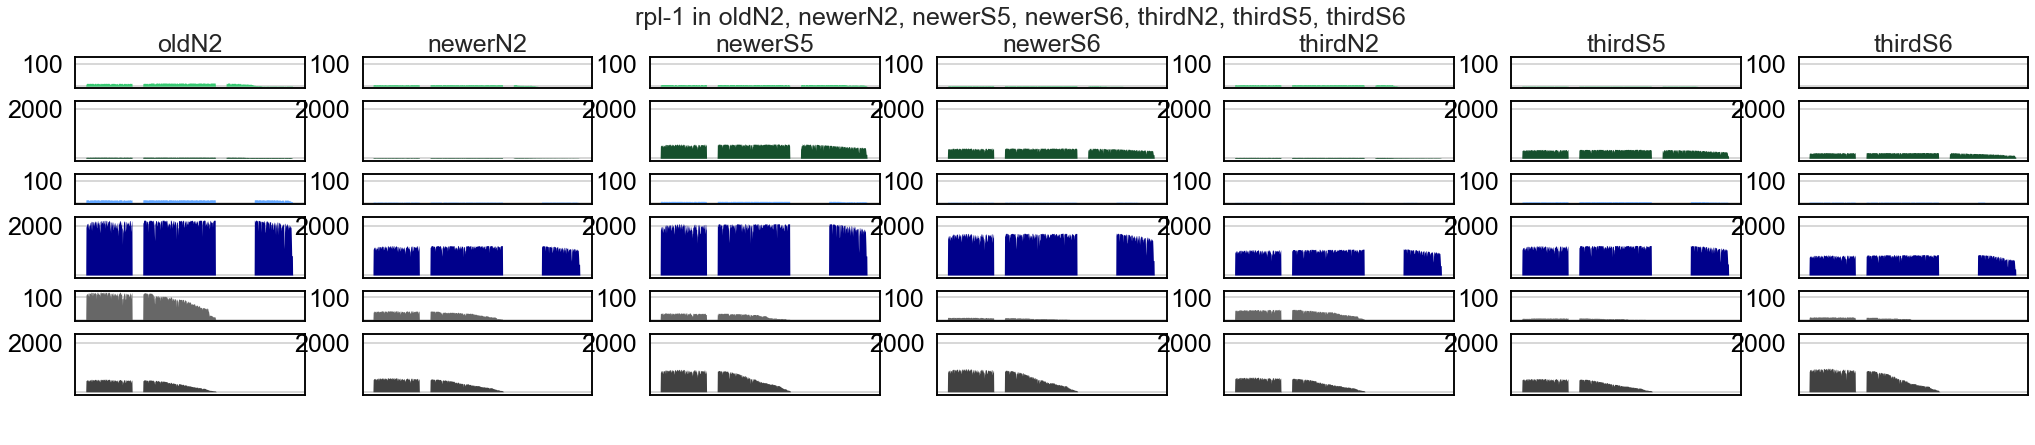

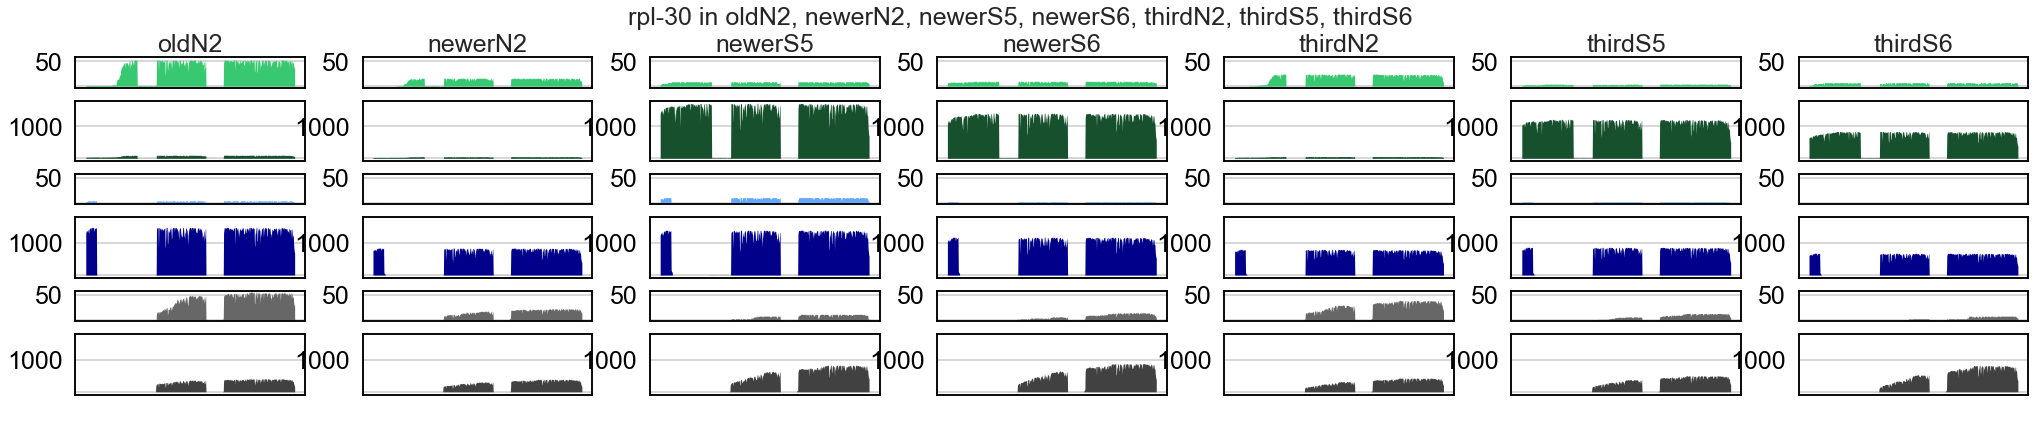

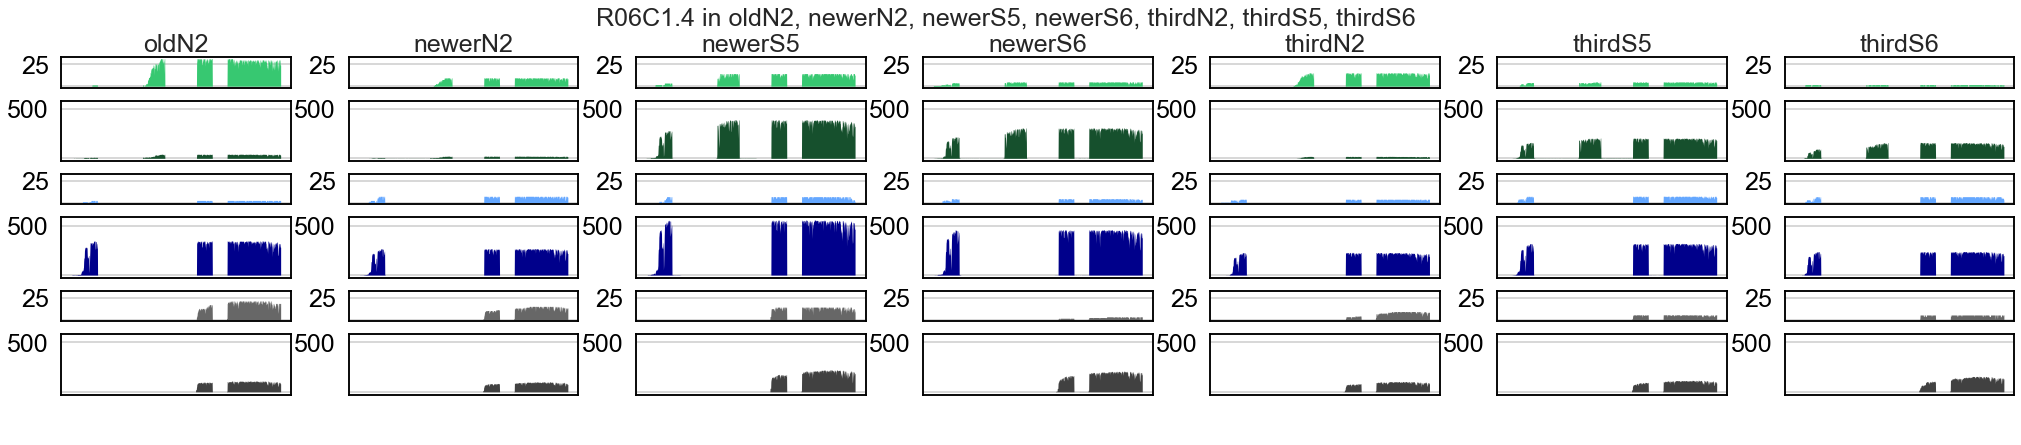

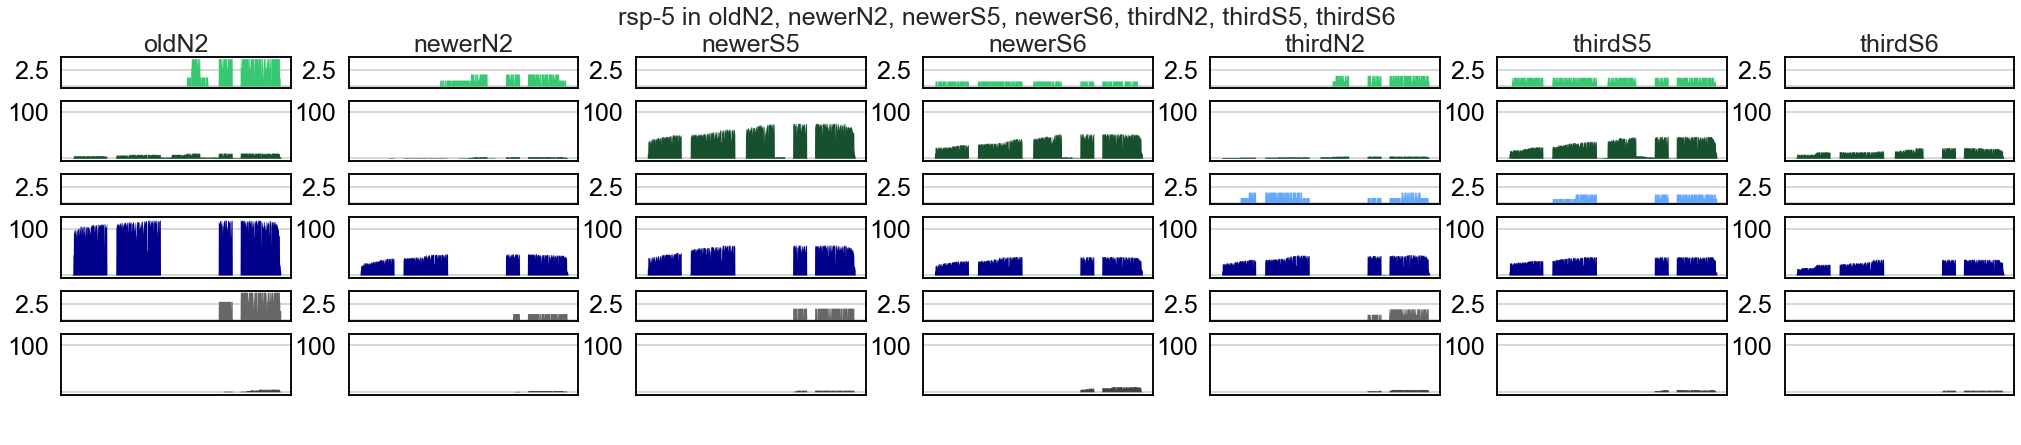

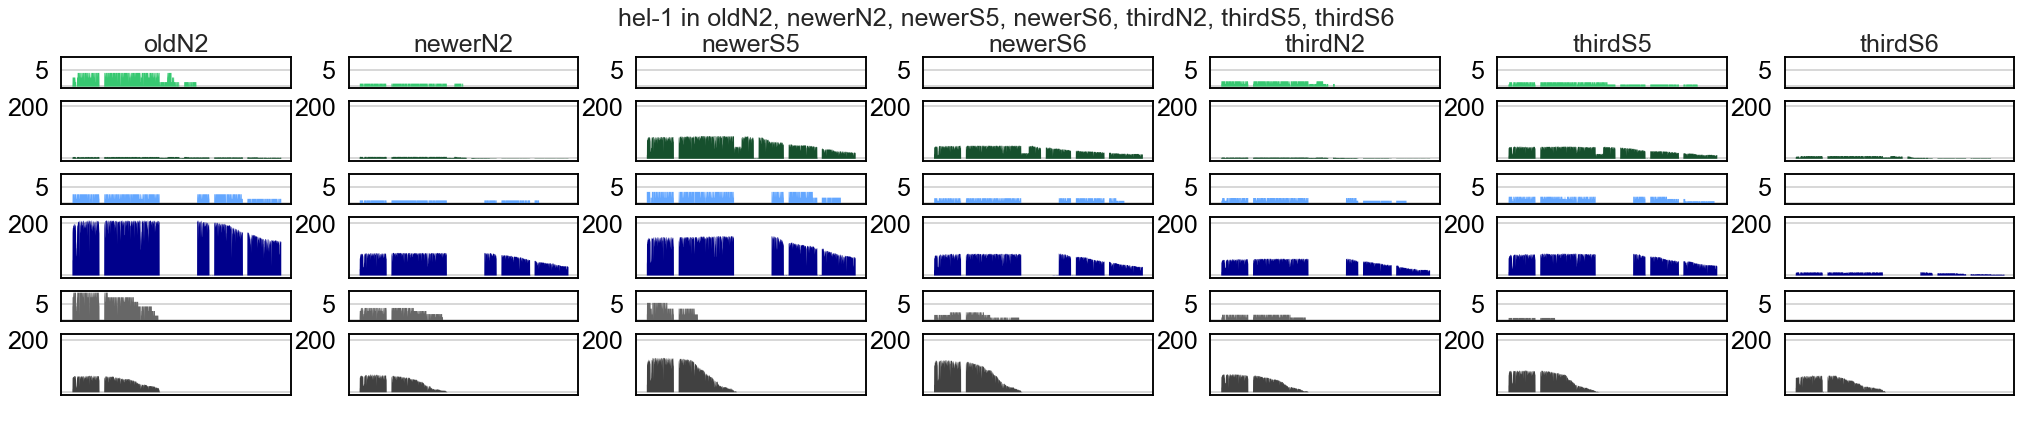

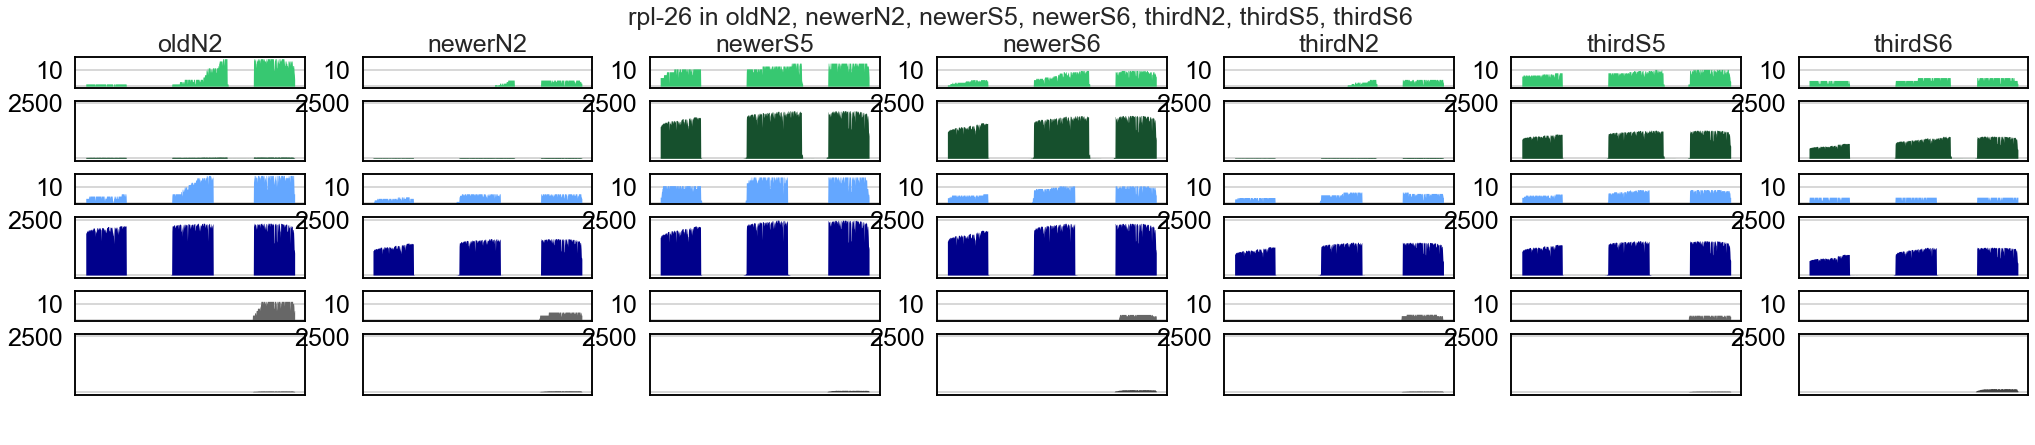

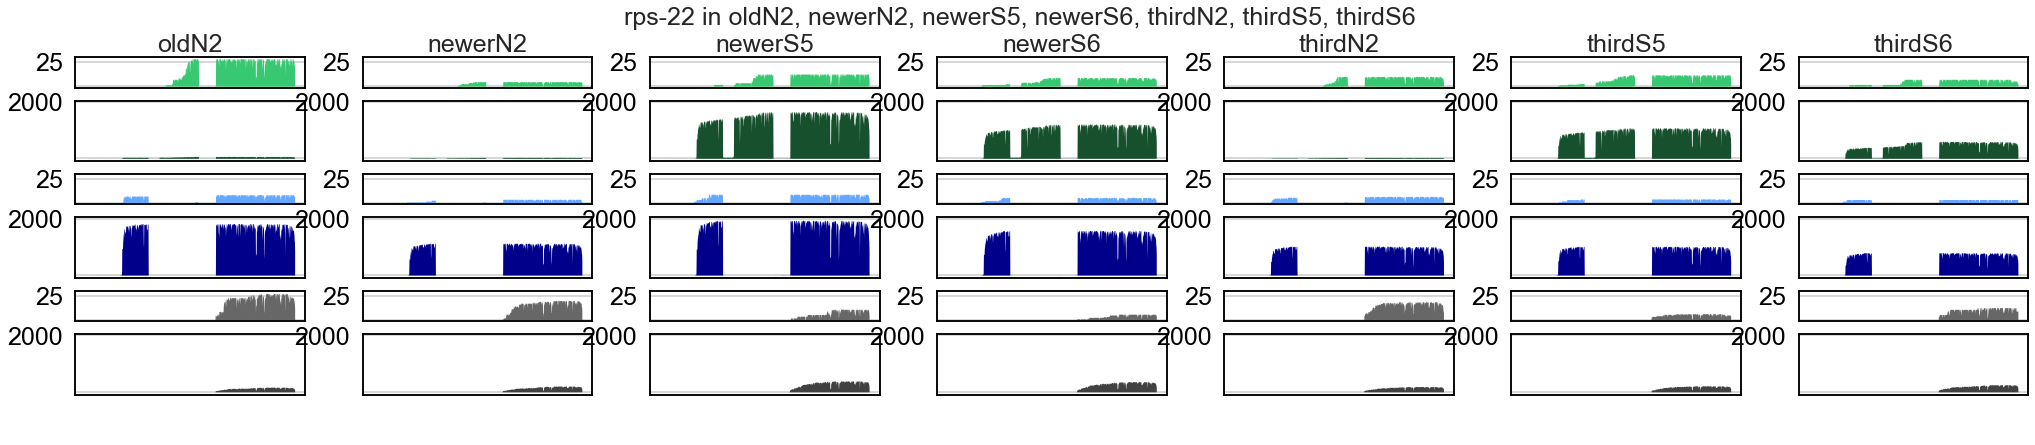

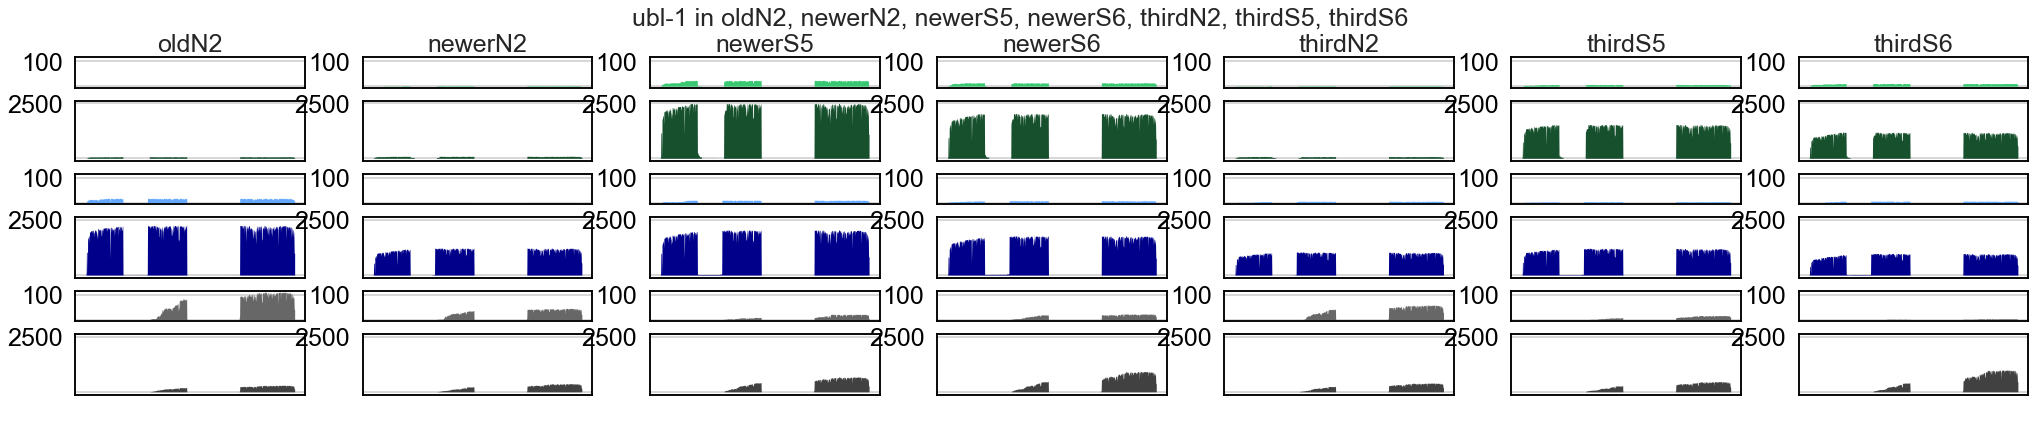

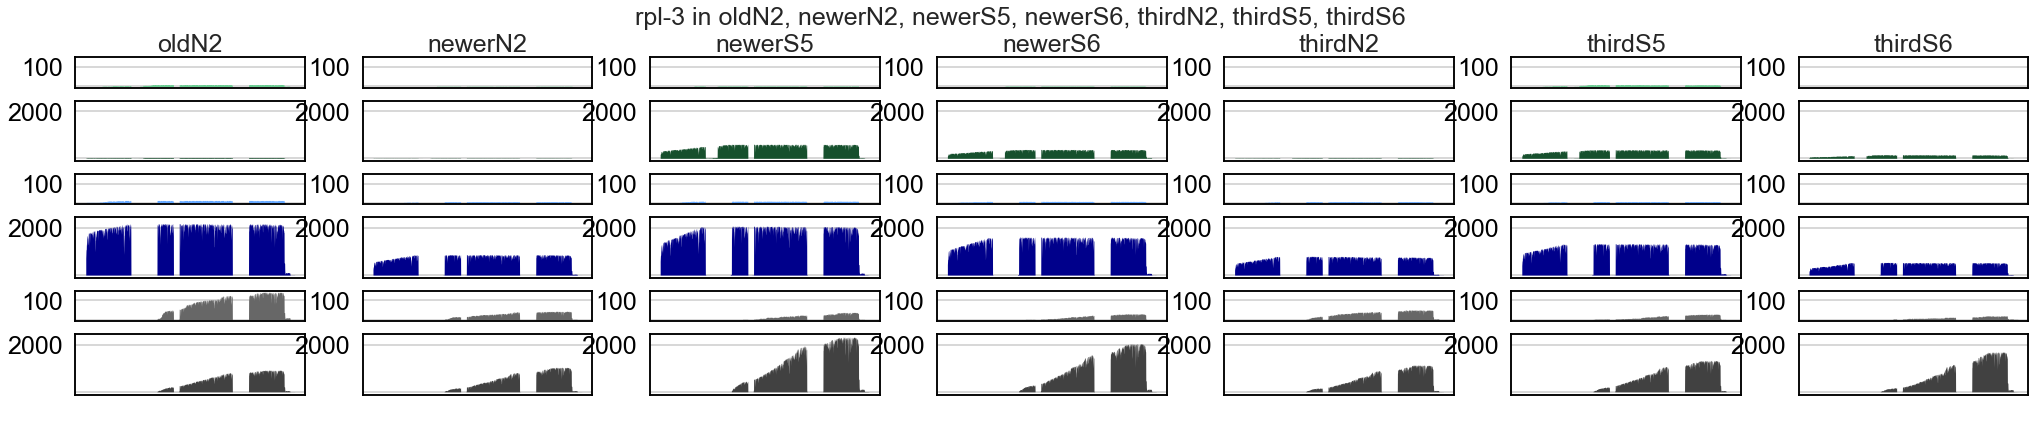

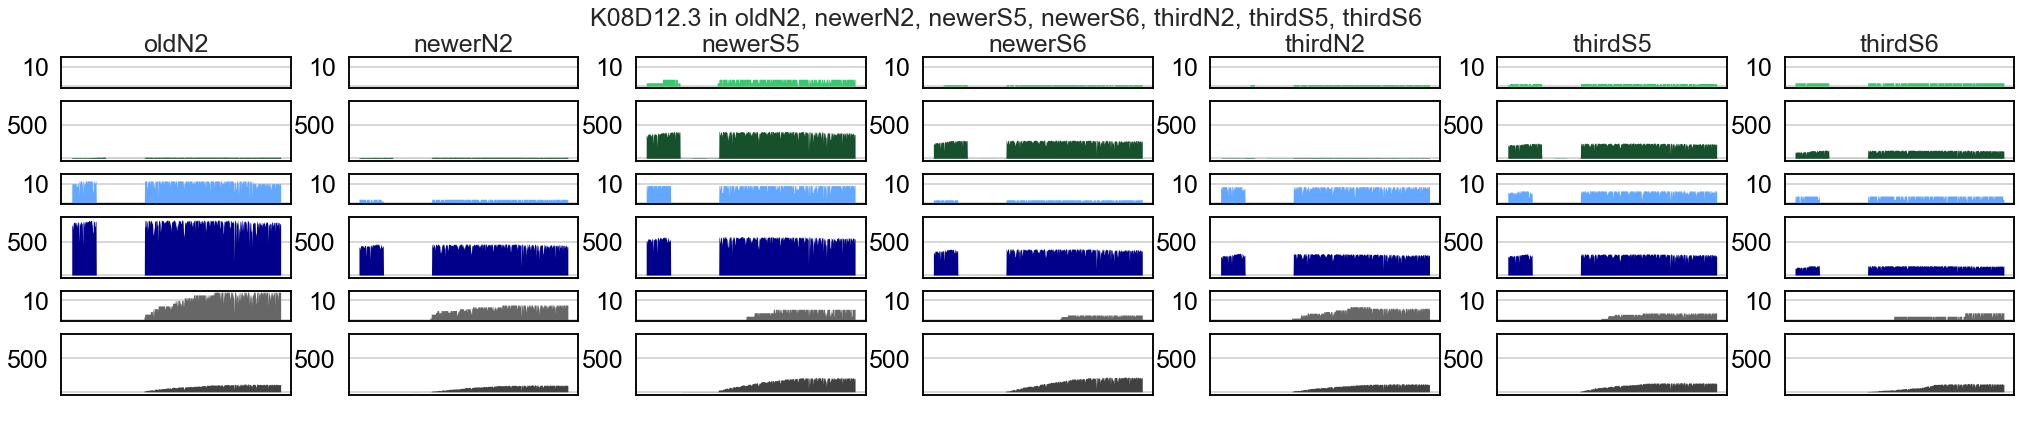

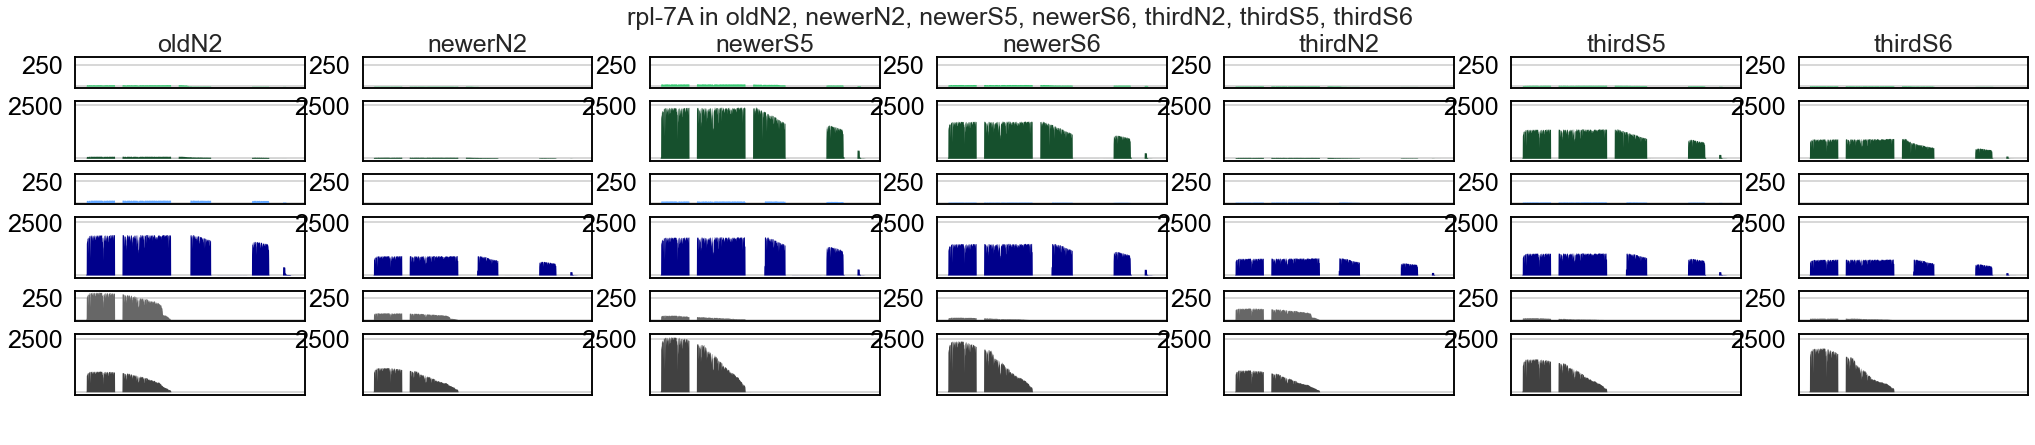

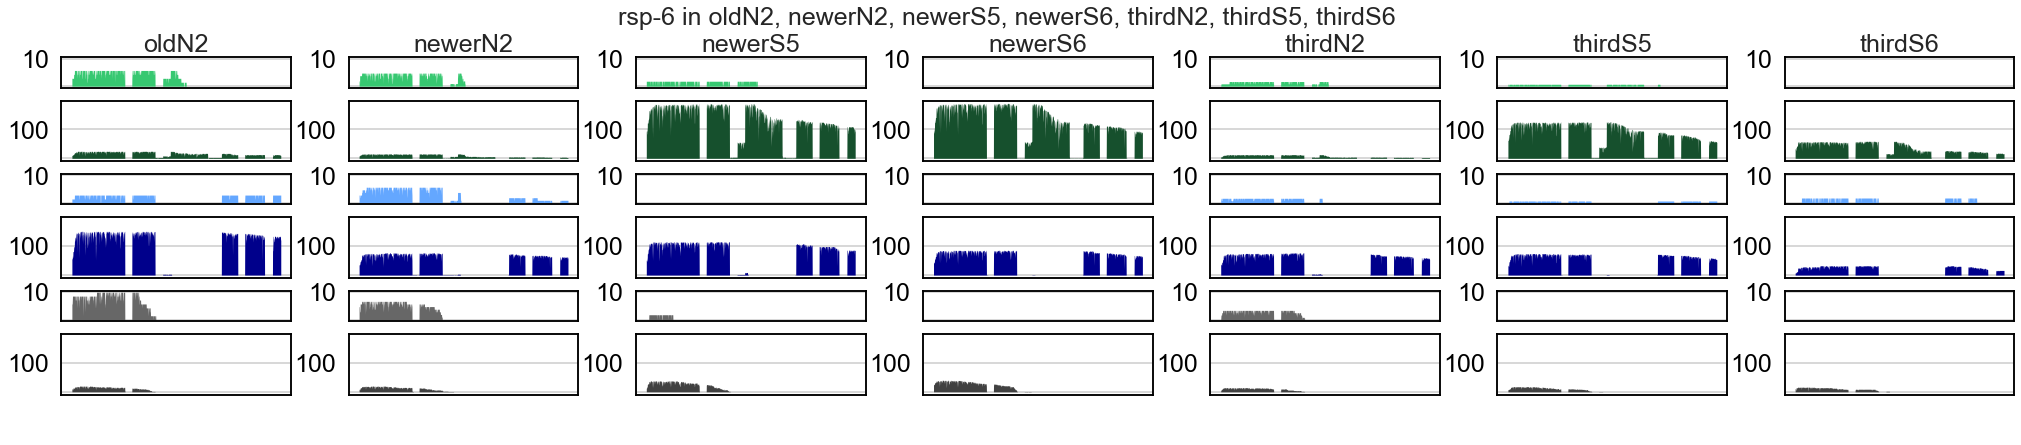

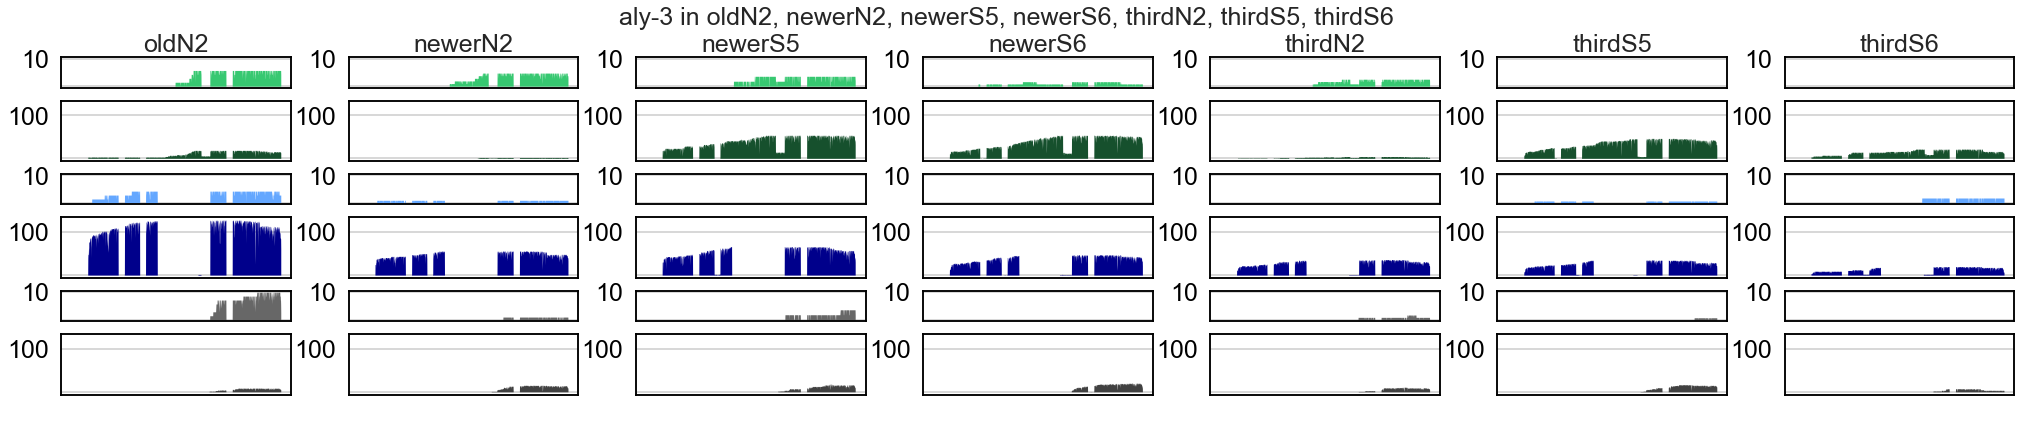

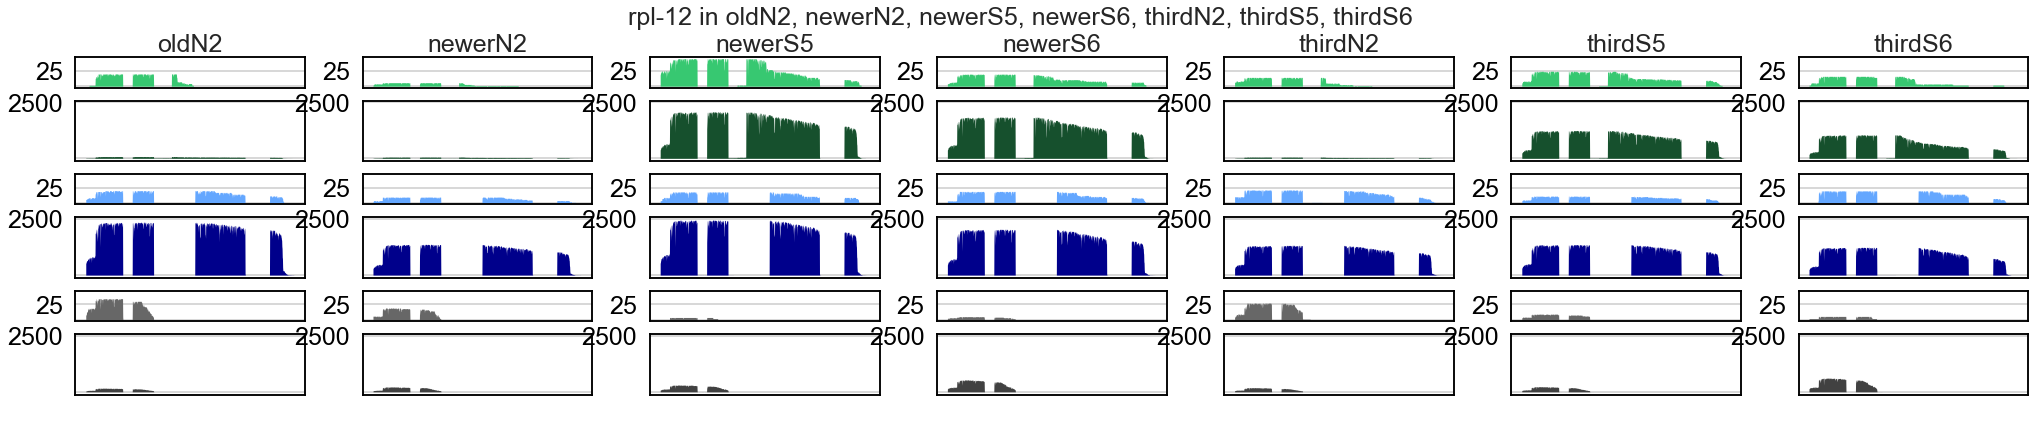

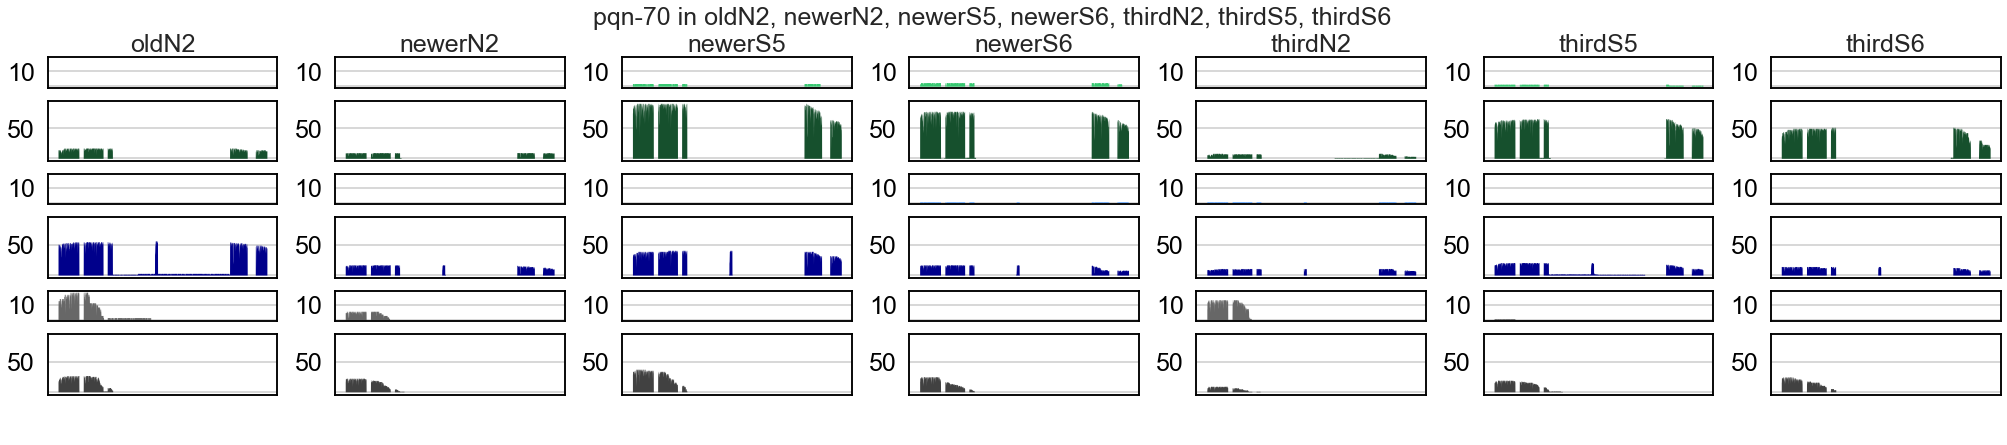

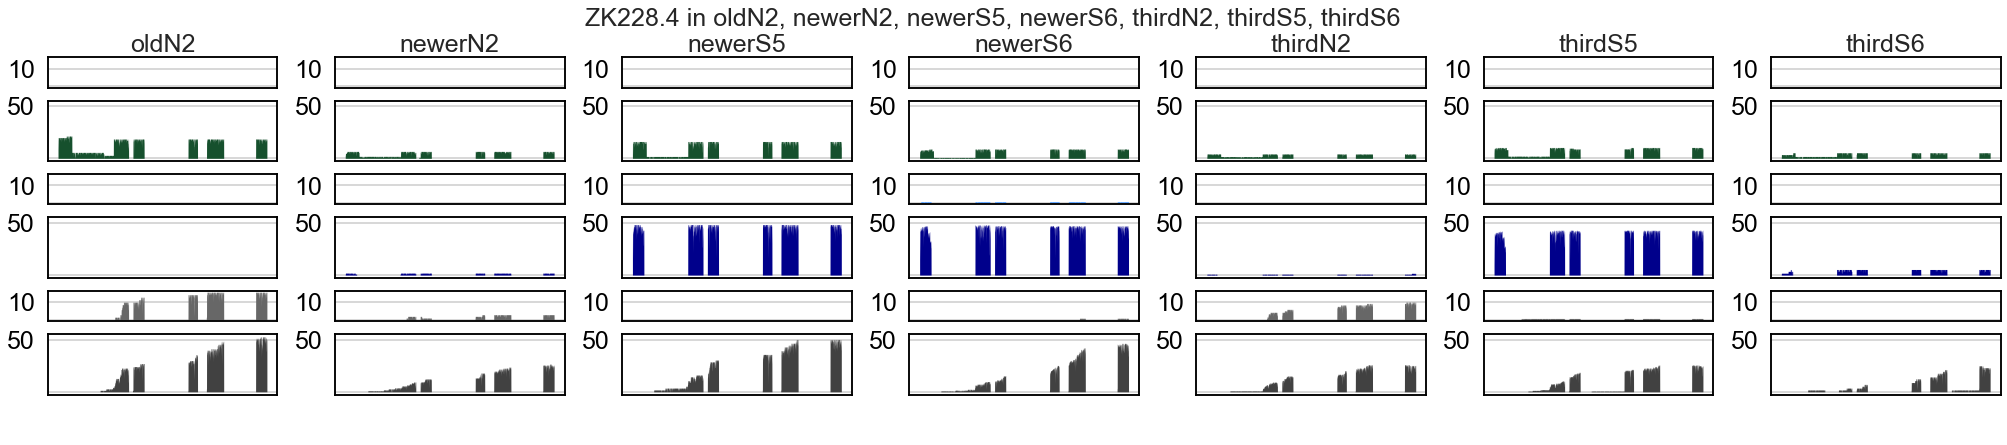

In [28]:
# This method is nice because it shares the axes scales between libs, but it takes a while!
plot_df = output_df[~output_df.t5.isna()].copy()

# genes_to_plot = ["ubl-1",
#                  "rps-22",
#                  # "rpl-30",
#                  ]
genes_to_plot = plot_df.gene_name.unique().tolist()
try:
    genes_to_plot.remove("non_nmd_gene")
except ValueError:
    pass
libs_to_plot = ["oldN2",
                "newerN2",
                "newerS5",
                "newerS6",
                "thirdN2",
                "thirdS5",
                "thirdS6",
                ]
fig_dict = {}
for gene in genes_to_plot:
    print(f"Working on {gene}...")
    fig_dict[gene], _ = plot_coverage_multilib(plot_df, gene, libs_to_plot,
                                               save_dir=f"/home/marcus/Insync/mviscard@ucsc.edu/"
                                                        f"Google Drive/insync_folder/"
                                                        f"NMD_cleavage_and_deadenylation_paper/"
                                                        f"raw_figures_from_python/{npC.get_dt()}_coverageOnly_plots",
                                               additional_width_factor=1.0,
                                               quiet=False,
                                               )

In [ ]:
sea.set_style("whitegrid")
sea.set_context("talk")
count_cutoff = 5
plot_df = output_df[~output_df.t5.isna()].copy()

genes_to_plot = ["ubl-1",
                 "rps-22",
                 "rpl-30",
                 ]
# genes_to_plot = plot_df.gene_name.unique()

libs_to_plot = [
    'oldN2',
    'oldS6',
    'newerN2',
    'newerS5',
    'newerS6',
    'thirdN2',
    'thirdS5',
    'thirdS6',
]
save_dir = f"/home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/{npC.get_dt()}_coverageAndTails_plots/"
if Path(save_dir).exists():
    print(f"Found existing directory at {save_dir}!")
else:
    print(f"Making new directory at {save_dir}!")
    Path(save_dir).mkdir(parents=True, exist_ok=True)

for gene in genes_to_plot:
    for lib in libs_to_plot:
        print(f"Working on {gene} in {lib}...")
        plot_tails_and_coverage(plot_df, gene, lib, quiet=True,
                                do_not_plot_less_than=count_cutoff,
                                save_dir=f"{save_dir}/{gene}",
                                skip_coverage=False,
                                )

In [10]:
def long_to_wide(input_df, wide_target_cols=['gene_rpm'], expand_col='lib', fillna=True) -> pd.DataFrame:
    w = input_df[wide_target_cols].unstack(level=expand_col)
    w.columns = w.columns.map('{0[0]}_{0[1]}'.format)
    if fillna:
        return w.reset_index().fillna(0)
    else:
        return w.reset_index()

from re import sub
def camel_case(s):
  s = sub(r"(_|-)+", " ", s).title().replace(" ", "")
  return ''.join([s[0].lower(), s[1:]])

def plot_tails_scatter_plotly(input_df, save_directory=None, split_column='lib',
                              flip_split_col_order=False, fill_na=False,
                              filter_w_counts_below=0, comment_to_pass=None,
                               plot_limits=(0, 150), plot_line_step=25) -> pd.DataFrame:
    """
    I want to produce basically the same plot as plot_tails_scatter but with ploty,
    specifically so that we can hover over the points and see the gene names, read counts, etc.
    
    This will help with deciding if we should be using some kind of cutoff for the weirder genes!
    """
    # going to take the dataframe processing straight from plot_tails_scatter!
    converter_dict = {"NMD'ed: +  t5: +": "Cleaved NMD Targets",
                      "NMD'ed: +  t5: -": "Full-Length NMD Targets",
                      "NMD'ed: -  t5: +": "Cleaved Non-Targets",
                      "NMD'ed: -  t5: -": "Full-Length Non-Targets",
                      }
    
    NMD_and_t5s = input_df['NMD_and_t5'].unique().tolist()
    if len(NMD_and_t5s) == 1:
        NMD_and_t5_inPlot = NMD_and_t5s[0]
        print(f"The plot dataframe contains only {NMD_and_t5_inPlot} targets!")
        single_NMD_and_t5 = True
        NMD_and_t5_texts = [converter_dict[NMD_and_t5_inPlot]]
    else:
        print(f"The plot dataframe contains {len(NMD_and_t5s)} different NMD_and_t5 targets!")
        print(f"These targets are: {', '.join(NMD_and_t5s)}")
        single_NMD_and_t5 = False
        NMD_and_t5_texts = [converter_dict[NMD_and_t5] for NMD_and_t5 in NMD_and_t5s]
    libs = input_df['lib'].unique().tolist()
    if len(libs) == 1:
        lib_inPlot = libs[0]
        print(f"The plot dataframe contains only {lib_inPlot} libraries!")
        single_lib = True
        lib_texts = [lib_inPlot]
    else:
        print(f"The plot dataframe contains {len(libs)} different libraries!")
        print(f"These libraries are: {', '.join(libs)}")
        single_lib = False
        lib_texts = libs
        
    split_col_values = input_df[split_column].unique().tolist()
    num_split_col_values = len(split_col_values)
    
    if num_split_col_values != 2:
        print(split_col_values)
        raise NotImplementedError(f"You provided a dataframe with {num_split_col_values} unique values in the split column ({', '.join(split_col_values)}), please only provide two. This will allow the values to be plotted!")
    if flip_split_col_order:
        y_val, x_val = split_col_values
    else:
        x_val, y_val = split_col_values
    
    if split_column == 'lib':
        x_title = f"Poly(A) Tail Length ({x_val})<br>[{NMD_and_t5_texts[0]}]"
        y_title = f"Poly(A) Tail Length ({y_val})<br>[{NMD_and_t5_texts[0]}]"
    else:
        x_title = f"Poly(A) Tail Length ({lib_texts[0]})<br>[{converter_dict[x_val]}]"
        y_title = f"Poly(A) Tail Length ({lib_texts[0]})<br>[{converter_dict[y_val]}]"
    
    groupby = input_df.groupby([split_column, "gene_name"])
    new_df = pd.DataFrame()
    new_df['mean_tail'] = groupby['polya_length'].mean()
    new_df['error'] = groupby['polya_length'].sem()  # standard error of the mean
    new_df['counts'] = groupby['polya_length'].count()
    new_df = long_to_wide(new_df,
                          wide_target_cols=['mean_tail', 'error', 'counts'],
                          expand_col=split_column,
                          fillna=fill_na)
    
    if filter_w_counts_below > 0:
        print(f"Dropping genes with less than {filter_w_counts_below} poly(A) tail called reads in either {x_val} or {y_val}...")
        failed_df = new_df[(new_df[f'counts_{x_val}'] < filter_w_counts_below) | (new_df[f'counts_{y_val}'] < filter_w_counts_below)]
        print(f"Failed genes:")
        print(f"{'gene_name':>15}{f'counts_{x_val}':>15}{f'counts_{y_val}':>15}")
        for index, row in failed_df.iterrows():
            print(f"{row['gene_name']:>15}{row[f'counts_{x_val}']:>15}{row[f'counts_{y_val}']:>15}")
        new_df = new_df[(new_df[f'counts_{x_val}'] > filter_w_counts_below) & (new_df[f'counts_{y_val}'] > filter_w_counts_below)]
        
    
    # Change plotly style to whitegrid
    px.defaults.template = "plotly_white"
    fig = px.scatter(new_df,
                     x=f"mean_tail_{x_val}",
                     y=f"mean_tail_{y_val}",
                     error_x=f'error_{x_val}',
                     error_y=f'error_{y_val}',
                     text='gene_name',
                     # textposition='top right',
                     hover_name='gene_name',
                     hover_data=[f'counts_{x_val}',
                                 f'counts_{y_val}'],
                     )
    fig.update_traces(marker=dict(size=8,
                                  line=dict(width=2,
                                            color='black'),
                                  color='black'),
                      textposition='top right',
                      )
    # Make the axis limits the same
    min_plot, max_plot = plot_limits
    fig.add_shape(type='line',
                  x0=min_plot-1, y0=min_plot-1,
                  x1=max_plot, y1=max_plot,
                  line=dict(color='DarkSlateGrey', width=2, dash='dash'),
                  )
    if comment_to_pass:
        fig.add_annotation(text=comment_to_pass,
                           xref="paper", yref="paper",
                           x=0.5, y=1.05,
                           showarrow=False,
                           font=dict(size=10),
                           )
    fig.update_layout(
        xaxis_title=x_title,
        yaxis_title=y_title,
        xaxis=dict(range=[min_plot-1, max_plot], constrain='domain'),
        yaxis=dict(range=[min_plot-1, max_plot], constrain='domain'),
        )
    # Make the overall plot square
    fig.update_layout(
        width=500,
        height=500,
        )
    fig.show(renderer='firefox')
    if Path(save_directory).exists():
        save_path = save_directory + f"/{npC.get_dt()}_tailScatter_{x_val}_vs_{y_val}"
        if single_NMD_and_t5:
            save_path += f".{camel_case(converter_dict[NMD_and_t5s[0]])}"
        else:
            save_path += f".{'-'.join([camel_case(converter_dict[x]) for x in NMD_and_t5s])}"
        print(f"Saving figure to {save_path}")
        fig.write_html(save_path + ".html")
        fig.write_image(save_path + ".png")
        fig.write_image(save_path + ".svg")
        new_df.to_csv(save_path + ".plotted.csv")
    else:
        print(f"Not saving figure to file... Please provide a save_directory that exists!")
    return new_df

In [12]:
collapse_cleaved_ambiguous = True
filter_sets_with_less_than = 10

target_lib_sets = (
                   # # ('oldN2', 'oldS6'),
                   # # ('newN2', 'newS5'),
                   # # ('newN2', 'newS6'),
                   # # ('newS5', 'newS6'),
                   # # ('oldS6', 'newS6'),
                   # # ('oldN2', 'newerN2'),
                   # # ('oldN2', 'oldS6'),
                   # # ('oldN2', 'newerS6'),
                   # # ('oldN2', 'newerS5'),
                   # ('newerS6', 'newerS5'),
                   # ('newerN2', 'newerS5'),
                   # ('newerN2', 'newerS6'),
                   ('newerS5', 'newerS6'),
                   # Third set of libs:
                   ('thirdN2', 'thirdS5'),
                   ('thirdN2', 'thirdS6'),
                   ('thirdS5', 'thirdS6'),
                   )
plot_df = output_df[~output_df.t5.isna()].copy()

save_dir = f"/home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/{npC.get_dt()}_tailScatters"
if not Path(save_dir).exists():
    Path(save_dir).mkdir()

nmd_sensitive_genes = plot_df.gene_name.unique()
print(f"Going to produce tail scatter plot with these {len(nmd_sensitive_genes)} genes:\n    {', '.join(nmd_sensitive_genes)}")

for lib_set in target_lib_sets:
    lib1, lib2 = lib_set
    print(f"Plotting tail scatter for libraries {lib_set[0]} & {lib_set[1]}:")
    lib_set_df = plot_df[plot_df.lib.isin(lib_set)].copy(deep=True)
    lib_set_read_count = lib_set_df.shape[0]
    
    lib_set_df = lib_set_df[lib_set_df.gene_name.isin(nmd_sensitive_genes)]
    curated_genes_read_count = lib_set_df.shape[0]
    
    print(f"Only {curated_genes_read_count} of {lib_set_read_count} ({curated_genes_read_count/lib_set_read_count:2.2%}) reads are within the curated list of NMD genes.")
    lib_set_df['NMD_Sensitive_Read'] = lib_set_df['nmd_assignment'].replace({'nmd_target': '+',
                                                                             'non_nmd_target': '-',
                                                                             'ambiguous': '~'})
    lib_set_df['NMD_and_t5'] = lib_set_df.apply(lambda row: f"NMD'ed: {str(row['NMD_Sensitive_Read'])}  t5: {row['t5']}", axis=1)
    if collapse_cleaved_ambiguous:
        lib_set_df['NMD_and_t5'] = lib_set_df['NMD_and_t5'].replace({'NMD\'ed: ~  t5: +': 'NMD\'ed: +  t5: +',})
    
    lib_set_full_length_target_df = lib_set_df.query("""NMD_and_t5 == "NMD'ed: +  t5: -" """)
    # print(lib_set_full_length_target_df)
    collapse_text_convert = {True: "Collapsed Ambiguous Cleaved Reads to NMD",
                             False: "Did Not Collapse Ambiguous Cleaved Reads to NMD"}
    plot_tails_scatter_plotly(lib_set_full_length_target_df, save_directory=save_dir,
                              plot_limits=(40, 140), plot_line_step=25,
                              flip_split_col_order=True,
                              filter_w_counts_below=filter_sets_with_less_than,
                              comment_to_pass=collapse_text_convert[collapse_cleaved_ambiguous] + f"<br>Cutoff of {filter_sets_with_less_than} reads",
                              )

Going to produce tail scatter plot with these 18 genes:
    non_nmd_gene, C53H9.2, rpl-1, rpl-30, R06C1.4, rsp-5, hel-1, rpl-26, rps-22, ubl-1, rpl-3, K08D12.3, rpl-7A, rsp-6, aly-3, rpl-12, pqn-70, ZK228.4
Plotting tail scatter for libraries newerS5 & newerS6:
Only 1784135 of 1784135 (100.00%) reads are within the curated list of NMD genes.
The plot dataframe contains only NMD'ed: +  t5: - targets!
The plot dataframe contains 2 different libraries!
These libraries are: newerS5, newerS6
Dropping genes with less than 10 poly(A) tail called reads in either newerS6 or newerS5...
Failed genes:
      gene_name counts_newerS6 counts_newerS5
        ZK228.4              7              9
Saving figure to /home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/230920_tailScatters/230920_tailScatter_newerS6_vs_newerS5.fullLengthNmdTargets
Plotting tail scatter for libraries thirdS5 & thirdS6:
Only 2001272 of 2001272 (100.00%) 

In [27]:
collapse_cleaved_ambiguous = True
filter_sets_with_less_than = 5

target_libraries = (# 'oldN2',
                    # 'newerN2',
                    # 'newerS6',
                    # 'newerS5',
                    # 'thirdN2',
                    'thirdS6',
                    'thirdS5',
                    )
NMD_and_t5s_to_compare = (("NMD'ed: +  t5: -", "NMD'ed: +  t5: +"),
                          ("NMD'ed: -  t5: -", "NMD'ed: +  t5: +"),
                          )
plot_df = output_df[~output_df.t5.isna()].copy()

for target_library in target_libraries:
    print(f"Plotting tail scatter for library {target_library}:")
    temp_save_dir = save_dir + f"/{target_library}"
    Path(temp_save_dir).mkdir(parents=True, exist_ok=True)
    lib_df = plot_df[plot_df.lib == target_library].copy(deep=True)
    lib_read_count = lib_df.shape[0]
    lib_df = lib_df[lib_df.gene_name.isin(nmd_sensitive_genes)]
    curated_genes_read_count = lib_df.shape[0]
    
    try:
        print(f"Only {curated_genes_read_count} of {lib_read_count} ({curated_genes_read_count/lib_read_count:2.2%}) reads are within the curated list of NMD genes.")
    except ZeroDivisionError:
        print(f"Only {curated_genes_read_count} reads are within the curated list of NMD genes.")
    lib_df['NMD_Sensitive_Read'] = lib_df['nmd_assignment'].replace({'nmd_target': '+',
                                                                     'non_nmd_target': '-',
                                                                     'ambiguous': '~'})
    lib_df['NMD_and_t5'] = lib_df.apply(lambda row: f"NMD'ed: {str(row['NMD_Sensitive_Read'])}  t5: {row['t5']}", axis=1)
    if collapse_cleaved_ambiguous:
        lib_df['NMD_and_t5'] = lib_df['NMD_and_t5'].replace({'NMD\'ed: ~  t5: +': 'NMD\'ed: +  t5: +',})
    
    for i, NMD_and_t5_to_compare in enumerate(NMD_and_t5s_to_compare):
        print(f"Going to split on NMD_and_t5, these are the values in the column pre-filtering:\n{lib_df.NMD_and_t5.unique()}")
        plot_df = lib_df[lib_df.NMD_and_t5.isin(NMD_and_t5_to_compare)]
        # if i == 0: flip = True
        # else: flip = False
        flip=False
        plot_tails_scatter_plotly(plot_df, split_column="NMD_and_t5", fill_na=True,
                                  flip_split_col_order=flip, save_directory=temp_save_dir,
                                  plot_limits=(30, 130), plot_line_step=25,
                                  filter_w_counts_below=filter_sets_with_less_than,
                                  comment_to_pass=collapse_text_convert[collapse_cleaved_ambiguous] + f"<br>Cutoff of {filter_sets_with_less_than} reads",
                                  )

Plotting tail scatter for library thirdS6:
Only 560899 of 560899 (100.00%) reads are within the curated list of NMD genes.
Going to split on NMD_and_t5, these are the values in the column pre-filtering:
["NMD'ed: -  t5: -" "NMD'ed: -  t5: +" "NMD'ed: +  t5: -"
 "NMD'ed: +  t5: +" "NMD'ed: ~  t5: -"]
The plot dataframe contains 2 different NMD_and_t5 targets!
These targets are: NMD'ed: +  t5: -, NMD'ed: +  t5: +
The plot dataframe contains only thirdS6 libraries!
Dropping genes with less than 5 poly(A) tail called reads in either NMD'ed: +  t5: - or NMD'ed: +  t5: +...
Failed genes:
      gene_namecounts_NMD'ed: +  t5: -counts_NMD'ed: +  t5: +
        C53H9.2           21.0            1.0
       K08D12.3           63.0            1.0
        R06C1.4           71.0            4.0
        ZK228.4            3.0            0.0
          aly-3           11.0            0.0
          hel-1            6.0            0.0
         pqn-70           24.0            0.0
          rpl-1          11

NotImplementedError: You provided a dataframe with 0 unique values in the split column (), please only provide two. This will allow the values to be plotted!

# Supplemental Tails CDFs
We want to have a plot that has three columns (newerN2, newerS6, newerS5), with a row for each gene we can ID

In [20]:
from tqdm.notebook import tqdm
tqdm.pandas()
target_df = output_df[~output_df.t5.isna()].copy()
target_df['NMD_Sensitive_Read'] = target_df['nmd_assignment'].replace({'nmd_target': '+',
                                                                       'non_nmd_target': '-',
                                                                       'ambiguous': '~'})
target_df['NMD_and_t5'] = target_df.progress_apply(lambda row: f"NMD'ed: {str(row['NMD_Sensitive_Read'])}  t5: {row['t5']}", axis=1)

  0%|          | 0/6963160 [00:00<?, ?it/s]

Plotting gene C53H9.2...
/+,-,-,-,C53H9.2,oldN2,0.674074074074074,0.00011307022913654225,343.0,0.00023785275806993363,
/+,-,~,-,C53H9.2,oldN2,0.43333333333333335,0.008873132995964709,1281.0,0.00490525380642155,
/+,-,~,/+,C53H9.2,oldN2,0.45517241379310347,0.009276191335105129,653.0,0.002983441059959564,
-,-,~,-,C53H9.2,oldN2,0.3913998744507219,0.0015168327277402956,992.0,0.002288128111280788,
-,-,~,/+,C53H9.2,oldN2,0.48659003831417624,0.00016495084657324098,414.0,0.0005043640254273635,
~,-,~,/+,C53H9.2,oldN2,0.13383985973115137,0.4380651131602669,3296.0,0.6928451865540963,
/+,-,-,-,C53H9.2,newerN2,0.7321428571428571,0.024242424242424242,52.0,0.0037296037296037296,
/+,-,~,-,C53H9.2,newerN2,0.5425257731958762,0.01532694879530028,609.0,0.007738338693112104,
/+,-,~,/+,C53H9.2,newerN2,0.425,0.21749327981660738,84.0,0.1314504582777567,
-,-,~,-,C53H9.2,newerN2,0.39322533136966126,0.2038272067333255,206.0,0.08443817495079764,
-,-,~,/+,C53H9.2,newerN2,0.5714285714285714,0.06258795384182382,18.0,

/usr/local/lib/python3.8/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10



/+,-,-,-,rpl-1,thirdS5,0.3368619659623199,4.9174990906815756e-33,413903.5,2.1337673977711423e-40,
/+,-,-,/+,rpl-1,thirdS5,0.500473933649289,0.1148352287526197,1542.0,0.07615985569514168,
/+,-,~,-,rpl-1,thirdS5,0.23387845285715458,3.429419809839754e-12,158523.5,3.2370027718523224e-16,
/+,-,~,/+,rpl-1,thirdS5,0.27995937711577523,0.5583377189012261,1783.0,0.3477341261366734,
-,-,-,/+,rpl-1,thirdS5,0.32430858806404655,0.5698362163598847,3995.5,0.5286752747218642,
-,-,~,-,rpl-1,thirdS5,0.12409592355177486,6.447103447370341e-06,345298.0,6.8012498840163455e-06,
-,-,~,/+,rpl-1,thirdS5,0.3001663547515076,0.4683465496000466,3476.0,0.20548398271206603,
-,/+,~,-,rpl-1,thirdS5,0.351473136915078,0.4693739830877155,1094.5,0.35330721951518473,
-,/+,~,/+,rpl-1,thirdS5,0.45714285714285713,0.43434343434343425,11.0,0.3434343434343435,
~,-,~,/+,rpl-1,thirdS5,0.25476603119584057,0.6725910185092575,1726.0,0.5090590459240402,
/+,-,-,-,rpl-1,thirdS6,0.3238303577729165,1.6380089239090048e-08,29433.0,6.657331339

/tmp/ipykernel_574238/764266532.py:70: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.



/+,-,-,-,rsp-6,newerS5,0.2161339421613394,0.12468503463841364,1844.5,0.2642449361574345,
/+,-,~,-,rsp-6,newerS5,0.17636986301369864,0.9467054273361181,268.0,0.7149694438968253,
-,-,~,-,rsp-6,newerS5,0.2861111111111111,0.5385659868740135,156.0,0.5661660728517268,
/+,-,-,-,rsp-6,newerS6,0.17098986285032797,0.07513276842479,5964.5,0.16073843209162686,
/+,-,~,-,rsp-6,newerS6,0.30007501875468867,0.013516852791946771,1847.0,0.006555349213224052,
-,-,~,-,rsp-6,newerS6,0.2109181141439206,0.23070772891846464,980.0,0.12483161495572374,
/+,-,-,-,rsp-6,thirdN2,0.4452054794520548,0.02326362418219568,673.0,0.0030804434722970122,
/+,-,~,-,rsp-6,thirdN2,0.4166666666666667,0.2681114551083592,65.0,0.45554509378932984,
-,-,~,-,rsp-6,thirdN2,0.5312024353120244,0.013214224193896285,201.0,0.05956983739662852,
/+,-,-,-,rsp-6,thirdS5,0.1659310813104736,0.09460582025938223,6915.5,0.028997492606882252,
/+,-,~,-,rsp-6,thirdS5,0.34549878345498786,0.06040003416563679,734.0,0.07027742632567348,
-,-,~,-,rsp-6,thirdS

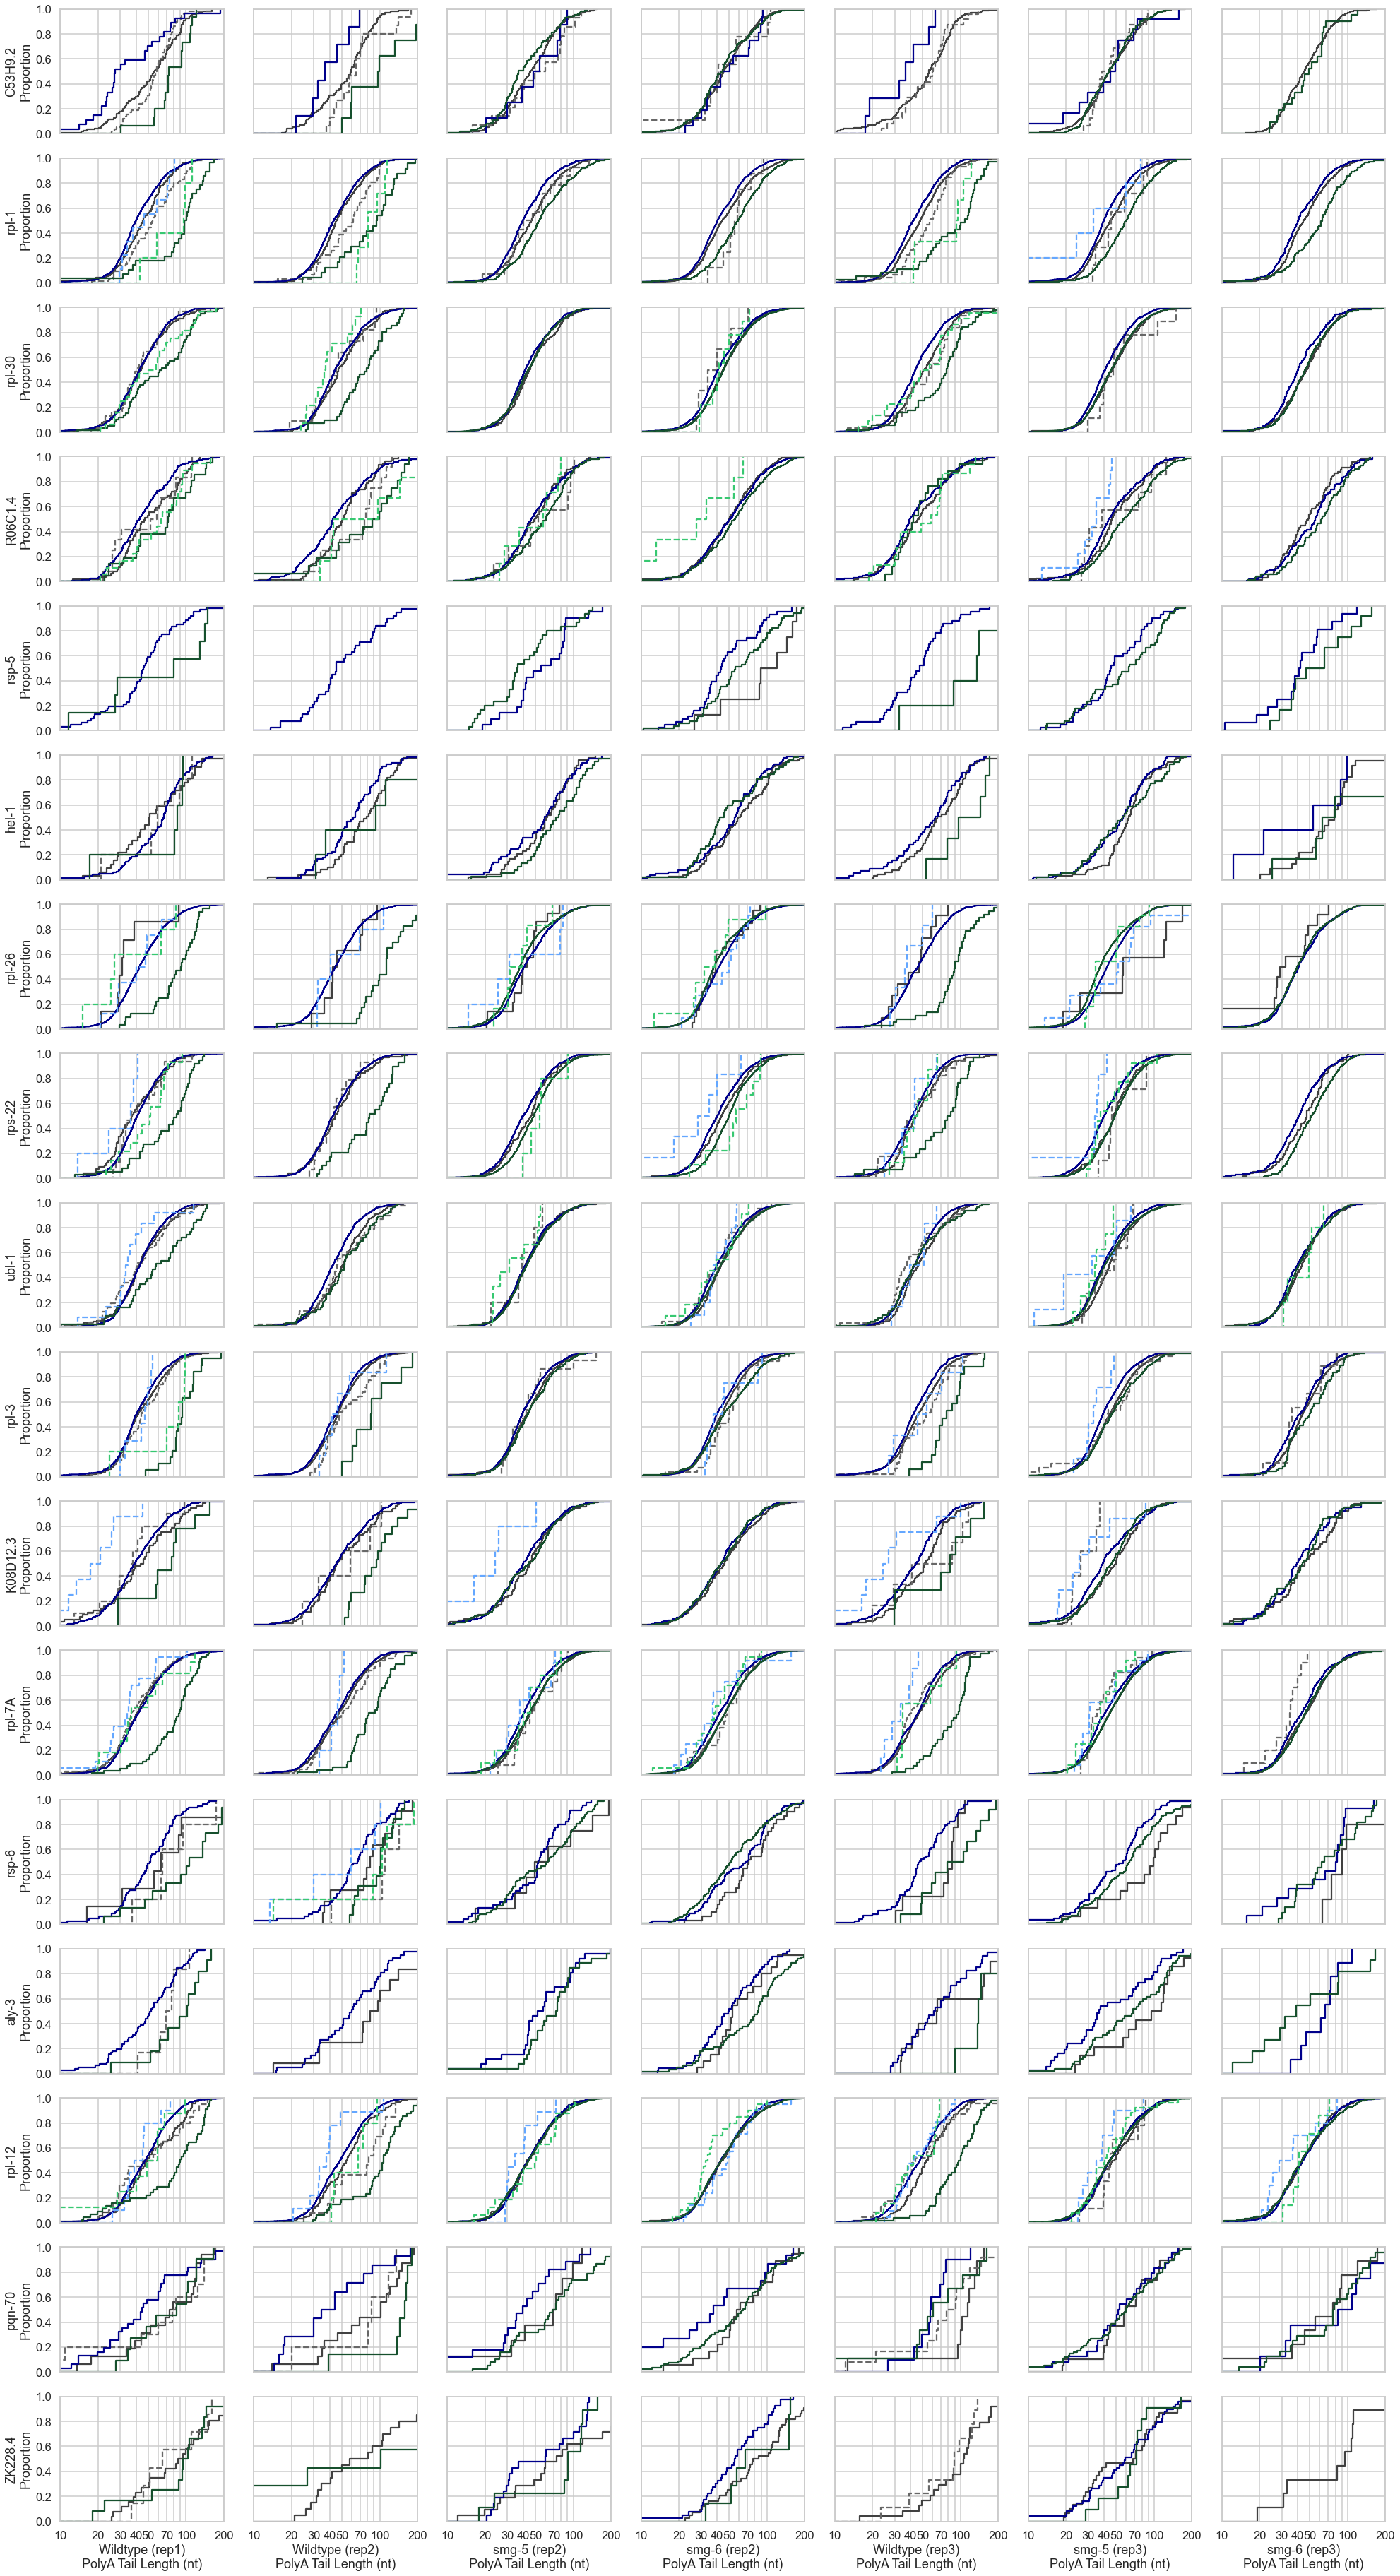

In [22]:
multiplot_save_dir = f"/home/marcus/Insync/mviscard@ucsc.edu/Google Drive/insync_folder/NMD_cleavage_and_deadenylation_paper/raw_figures_from_python/tail_cdf_multiplots"
Path(multiplot_save_dir).mkdir(parents=True, exist_ok=True)
target_df = target_df[target_df.gene_name != 'non_nmd_gene']
genes_to_plot = target_df.gene_name.unique()
num_genes = len(genes_to_plot)
libs_to_plot = ['oldN2', 'newerN2', 'newerS5', 'newerS6', 'thirdN2', 'thirdS5', 'thirdS6']
num_libs = len(libs_to_plot)
lib_converter = {'oldN2': 'Wildtype (rep1)',
                 'newerN2': 'Wildtype (rep2)',
                 'newerS6': 'smg-6 (rep2)',
                 'newerS5': 'smg-5 (rep2)',
                 'thirdN2': 'Wildtype (rep3)',
                 'thirdS6': 'smg-6 (rep3)',
                 'thirdS5': 'smg-5 (rep3)',}
sea.set_style("whitegrid")

fig, axes = plt.subplots(num_genes, num_libs,
                         figsize=(4 * num_libs, 3 * num_genes),
                         sharex='all', sharey='all')
for row_i, gene_name in enumerate(genes_to_plot):
    print(f"Plotting gene {gene_name}...")
    gene_df = target_df.query(f"gene_name == @gene_name")
    for col_i, lib in enumerate(libs_to_plot):
        gene_lib_df = gene_df.query(f"lib == @lib")
        # axes[row_i][col_i].annotate(f"{gene_name}\n{lib_converter[lib]}",
        #              xy=(0.5, 1),
        #              xycoords='axes fraction',
        #              ha='center', va='top')
        plots_tails_ecdf(gene_lib_df, gene_name,
                         lib_target=lib,
                         save_dir=None,
                         given_ax=axes[row_i][col_i],
                         do_not_plot_less_than=5,)
        if col_i == 0:
            axes[row_i][col_i].set_ylabel(f"{gene_name}\nProportion")
        if row_i == num_genes - 1:
            axes[row_i][col_i].set_xlabel(f"{lib_converter[lib]}\nPolyA Tail Length (nt)")
plt.tight_layout()
save_name = f"{npC.get_dt()}tail_cdf_multiplot_{num_genes:0>2}genes_{num_libs:0>2}libs"
dpi = 96
for file_type in ['png', 'svg']:
    plt.savefig(f"{multiplot_save_dir}/{save_name}.{dpi}dpi.{file_type}", dpi=dpi)
plt.show()